<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Problem-Setup" data-toc-modified-id="Problem-Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Problem Setup</a></span></li><li><span><a href="#The-solution" data-toc-modified-id="The-solution-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>The solution</a></span></li><li><span><a href="#Define-an-objective-function" data-toc-modified-id="Define-an-objective-function-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Define an objective function</a></span></li><li><span><a href="#Pyro-implementation" data-toc-modified-id="Pyro-implementation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Pyro implementation</a></span><ul class="toc-item"><li><span><a href="#Setting-a-Gaussian-Process-prior" data-toc-modified-id="Setting-a-Gaussian-Process-prior-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Setting a Gaussian Process prior</a></span></li><li><span><a href="#Define-an-acquisition-function" data-toc-modified-id="Define-an-acquisition-function-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Define an acquisition function</a></span></li><li><span><a href="#The-inner-loop-of-Bayesian-Optimization" data-toc-modified-id="The-inner-loop-of-Bayesian-Optimization-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>The inner loop of Bayesian Optimization</a></span></li></ul></li><li><span><a href="#Running-the-algorithm" data-toc-modified-id="Running-the-algorithm-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Running the algorithm</a></span></li><li><span><a href="#Pyro-+-GPyTorch" data-toc-modified-id="Pyro-+-GPyTorch-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Pyro + GPyTorch</a></span></li><li><span><a href="#BoTorch-Implementation" data-toc-modified-id="BoTorch-Implementation-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>BoTorch Implementation</a></span><ul class="toc-item"><li><span><a href="#Intro" data-toc-modified-id="Intro-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Intro</a></span></li><li><span><a href="#Show-Objective-function" data-toc-modified-id="Show-Objective-function-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Show Objective function</a></span></li><li><span><a href="#Generate-initial-samples" data-toc-modified-id="Generate-initial-samples-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Generate initial samples</a></span></li><li><span><a href="#Fit-a-Gaussian-Process-model-to-data" data-toc-modified-id="Fit-a-Gaussian-Process-model-to-data-7.4"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>Fit a Gaussian Process model to data</a></span></li><li><span><a href="#Construct-an-acquisition-function" data-toc-modified-id="Construct-an-acquisition-function-7.5"><span class="toc-item-num">7.5&nbsp;&nbsp;</span>Construct an acquisition function</a></span></li><li><span><a href="#Optimize-the-acquisition-function" data-toc-modified-id="Optimize-the-acquisition-function-7.6"><span class="toc-item-num">7.6&nbsp;&nbsp;</span>Optimize the acquisition function</a></span></li><li><span><a href="#Optimization-Loop" data-toc-modified-id="Optimization-Loop-7.7"><span class="toc-item-num">7.7&nbsp;&nbsp;</span>Optimization Loop</a></span></li><li><span><a href="#Outro" data-toc-modified-id="Outro-7.8"><span class="toc-item-num">7.8&nbsp;&nbsp;</span>Outro</a></span></li></ul></li><li><span><a href="#Gpy-Implementation" data-toc-modified-id="Gpy-Implementation-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Gpy Implementation</a></span><ul class="toc-item"><li><span><a href="#Lets-sample-5-data-points-and-fit-a-GP-to-the-data." data-toc-modified-id="Lets-sample-5-data-points-and-fit-a-GP-to-the-data.-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Lets sample 5 data points and fit a GP to the data.</a></span></li><li><span><a href="#sample-the-GP-given-our-measured-data-points:" data-toc-modified-id="sample-the-GP-given-our-measured-data-points:-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>sample the GP given our measured data points:</a></span></li><li><span><a href="#The-model" data-toc-modified-id="The-model-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>The model</a></span></li><li><span><a href="#Loop-of-Bayesian-Optimization" data-toc-modified-id="Loop-of-Bayesian-Optimization-8.4"><span class="toc-item-num">8.4&nbsp;&nbsp;</span>Loop of Bayesian Optimization</a></span></li></ul></li></ul></div>

# Bayesian Optimization

adapted form https://pyro.ai/examples/bo.html

In [1]:
# !pip3 install pyro-ppl 
# !pip3  gpytorch

# !pip3 install torch==1.9.0+cpu -f https://download.pytorch.org/whl/torch_stable.html
# or 
# pip3 install torch==1.9.0+cu111  -f https://download.pytorch.org/whl/torch_stable.html

## Problem Setup

Bayesian optimization is a powerful strategy for minimizing (or maximizing) objective functions that are costly to evaluate.


Given a minimization problem

\begin{align*}
x^* =  \arg \min f(x)
\end{align*}

- $f$  is a fixed objective function that we can evaluate pointwise. 
- Here we assume that we do not have access to the gradient of $f$. 
- We also allow for the possibility that evaluations of $f$ are noisy.




## The solution 

To solve the minimization problem, we will construct a sequence of points $\{x_n\}$ that converge to $x^*$.


The Bayesian optimization strategy works as follows:

1. Place a prior on the objective function $f$ . Each time we evaluate $f$  at a new point $x_n$, we update our model for $f(x)$. This model serves as a surrogate objective function and reflects our beliefs about $f$ [in particular it reflects our beliefs about where we expect $f(x)$ to be close to $f(x^∗)$ ]. Since we are being Bayesian, our beliefs are encoded in a posterior that allows us to systematically reason about the uncertainty of our model predictions.

2. Use the posterior to derive an “acquisition” function $\alpha(x)$ that is easy to evaluate and differentiate (so that optimizing $\alpha(x)$ is easy). In contrast to $f(x)$, we will generally evaluate $\alpha(x)$ at many points $x$, since doing so will be cheap.

3. Repeat until convergence:

    - Use the acquisition function to derive the next query point according to
    \begin{align*}
        x_{n+1}= \arg \min \alpha(x)
    \end{align*}
 
    - Evaluate $f(x_{n+1})$ and update the posterior.



In this tutorial, our model for f will be a Gaussian process. In particular we will see how to use the Gaussian Process module in Pyro to implement a simple Bayesian optimization procedure.

In [143]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import torch
import torch.autograd as autograd
import torch.optim as optim
from torch.distributions import constraints, transform_to



# GPy: Gaussian processes library
import GPy
import GPyOpt


import gpytorch

import pyro
import pyro.contrib.gp as gp
assert pyro.__version__.startswith('1.7.0')
pyro.set_rng_seed(1)


import plotly.graph_objects as go
import numpy as np 
np.random.seed(33)

## Define an objective function



For the purposes of demonstration, the objective function we are going to consider is the [https://www.sfu.ca/~ssurjano/forretal08.html] (Forrester et al. (2008) function):

\begin{align*}
f(x) = (6x-2)^2 \sin(12x-4), \qquad x \in [0,1 ]
\end{align*}

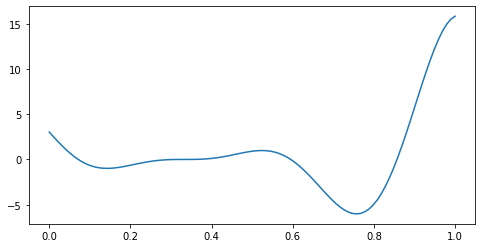

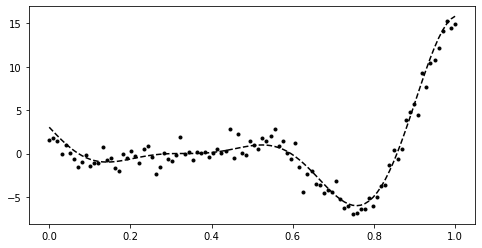

In [144]:
def f(x):
    return (6 * x - 2)**2 * torch.sin(12 * x - 4)

# f = lambda : (6 * x - 2)**2 * torch.sin(12 * x - 4)
x = torch.linspace(0, 1)
plt.figure(figsize=(8, 4))
plt.plot(x.numpy(), f(x).numpy())
plt.show()

y = f(x) 
y_noise = y + torch.normal(0., 1, (x.shape[0],1)).view(-1)
# Show function with noise
plt.figure(figsize=(8, 4))
plt.plot(x.numpy(),y.numpy(),'k--')
plt.plot(x.numpy(), y_noise .numpy() ,'k.')


## Pyro implementation

### Setting a Gaussian Process prior

- Gaussian processes are a popular choice for a function priors due to their power and flexibility. 

- The core of a Gaussian Process is its covariance function $k$, which governs the similarity of $f(x)$ for pairs of input points. 

- Here we will use a Gaussian Process as our prior for the objective function $f$. Given inputs $X$ and the corresponding noisy observations $y$, the model takes the form


\begin{align*}
f &\sim \text{MultivariateNormal} (0, k(X,Y)) \\
y &\sim  f+ \varepsilon
\end{align*}


$\varepsilon$ is the  Gaussian noise nad $k(X,X)$ is a covariance matrix whose entries are given by $k(x,x'$) at each pair of inputs $(x,x'$)

In [145]:
torch.manual_seed(56)
torch.rand(5)

tensor([0.9531, 0.5607, 0.3535, 0.9455, 0.4676])

In [146]:
# initialize the model with four input points: 0.0, 0.33, 0.66, 1.0
# choose the Matern kernel with v = 5/2

torch.manual_seed(56)
#X = torch.tensor([0.0, 0.22, 0.56, 0.76, 1.0])
num_measurements = 5
X = torch.rand(num_measurements)
# Get the function value with noise
y = f(X)  + torch.normal(0., 1, (X.shape[0],1)).view(-1)

gpmodel = gp.models.GPRegression(X, y, gp.kernels.Matern52(input_dim=1),
                                 noise=torch.tensor(0.02), jitter=1.0e-4) # noise is the varaince mean = 0 by default 

In [147]:
def update_posterior(x_new):
    y = f(x_new) + torch.normal(0., 1, (x_new.shape[0],1)).view(-1)# evaluate f at new point.
    X = torch.cat([gpmodel.X, x_new]) # incorporate new evaluation
    y = torch.cat([gpmodel.y, y])
    gpmodel.set_data(X, y)
    # optimize the GP hyperparameters using Adam with lr=0.001
    optimizer = torch.optim.Adam(gpmodel.parameters(), lr=0.001)
    gp.util.train(gpmodel, optimizer)

###  Define an acquisition function

we will use the Lower Confidence Bound acquisition function given by

\begin{align*}
\alpha(x) = \mu(x) - k\sigma(x)
\end{align*}

where $\mu(x)$ and $\sigma(x)$ are are the mean and square root variance of the posterior at the point $x$, and the arbitrary constant $κ>0$ controls the trade-off between exploitation and exploration

In [148]:
# we will use k =10
def lower_confidence_bound(x, kappa=5):
    mu, variance = gpmodel(x, full_cov=False, noiseless=False)
    sigma = variance.sqrt()
    return mu - kappa * sigma

The final component we need is a way to find (approximate) minimizing points $x_{min}$ of the acquisition function. There are several ways to proceed, including gradient-based and non-gradient-based techniques. 
One of the possible drawbacks of gradient descent methods is that the minimization algorithm can get stuck at a local minimum. In this tutorial, we adopt a (very) simple approach to address this issue:


- First, we seed our minimization algorithm with 5 different values: i) one is chosen to be $x_{n−1}$, i.e. the candidate $x$ used in the previous step; and ii) four are chosen uniformly at random from the domain of the objective function.

- We then run the minimization algorithm to approximate convergence for each seed value.

- Finally, from the five candidate $x$ identified by the minimization algorithm, we select the one that minimizes the acquisition function.

In [149]:
# Here we will follow the gradient-based approach.

def find_a_candidate(x_init, lower_bound=0, upper_bound=1):
    # transform x to an unconstrained domain
    constraint = constraints.interval(lower_bound, upper_bound)
    unconstrained_x_init = transform_to(constraint).inv(x_init)
    unconstrained_x = unconstrained_x_init.clone().detach().requires_grad_(True)
    minimizer = optim.LBFGS([unconstrained_x], line_search_fn='strong_wolfe')

    def closure():
        minimizer.zero_grad()
        x = transform_to(constraint)(unconstrained_x)
        y = lower_confidence_bound(x)
        autograd.backward(unconstrained_x, autograd.grad(y, unconstrained_x))
        return y

    minimizer.step(closure)
    # after finding a candidate in the unconstrained domain,
    # convert it back to original domain.
    x = transform_to(constraint)(unconstrained_x)
    return x.detach()

### The inner loop of Bayesian Optimization

In [150]:
def next_x(lower_bound=0, upper_bound=1, num_candidates=5):
    candidates = []
    values = []

    x_init = gpmodel.X[-1:]
    for i in range(num_candidates):
        x = find_a_candidate(x_init, lower_bound, upper_bound)
        y = lower_confidence_bound(x)
        candidates.append(x)
        values.append(y)
        x_init = x.new_empty(1).uniform_(lower_bound, upper_bound)

    argmin = torch.min(torch.cat(values), dim=0)[1].item()
    return candidates[argmin]

## Running the algorithm

In [151]:
def plot( xmin, xlabel=None, with_title=True, k=5):
    plt.figure(figsize = (16,4))
    plt.subplot(1,2,1)
    xlabel = "xmin" if xlabel is None else "x{}".format(xlabel)
    Xnew = torch.linspace(-0.1, 1.1)
#     ax1 = plt.subplot(gs[0])
    plt.plot(gpmodel.X.numpy(), gpmodel.y.numpy(), "kx")  # plot all observed data
    with torch.no_grad():
        loc, var = gpmodel(Xnew, full_cov=False, noiseless=False)
        sd = var.sqrt()
        plt.plot(Xnew.numpy(), loc.numpy(), "r", lw=2)  # plot predictive mean
        plt.fill_between(Xnew.numpy(), loc.numpy() - k*sd.numpy(), loc.numpy() + k*sd.numpy(),
                         color="C0", alpha=0.3)  # plot uncertainty intervals
    plt.xlim(-0.1, 1.1)
    plt.title("Find {}".format(xlabel))
    if with_title:
        plt.ylabel("Gaussian Process Regression")

#     ax2 = plt.subplot(gs[1])
    plt.subplot(1,2,2)
    with torch.no_grad():
        # plot the acquisition function
        plt.plot(Xnew.numpy(), lower_confidence_bound(Xnew).numpy())
        # plot the new candidate point
        plt.plot(xmin.numpy(), lower_confidence_bound(xmin).numpy(), "^", markersize=10,
                 label="{} = {:.5f}".format(xlabel, xmin.item()))
    plt.xlim(-0.1, 1.1)
    if with_title:
        plt.ylabel("Acquisition Function")
    plt.legend(loc=1)

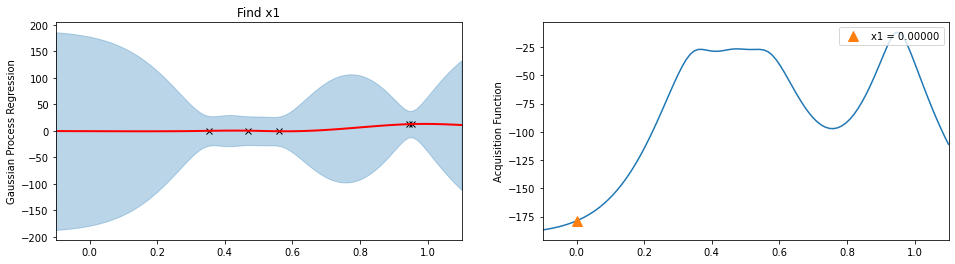

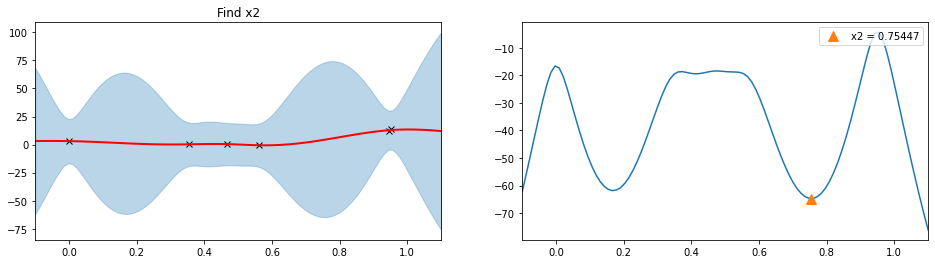

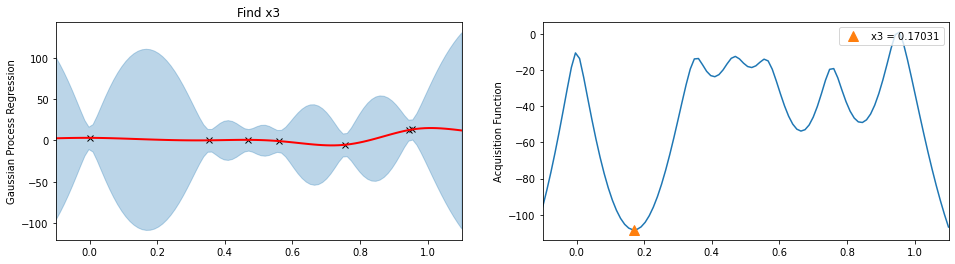

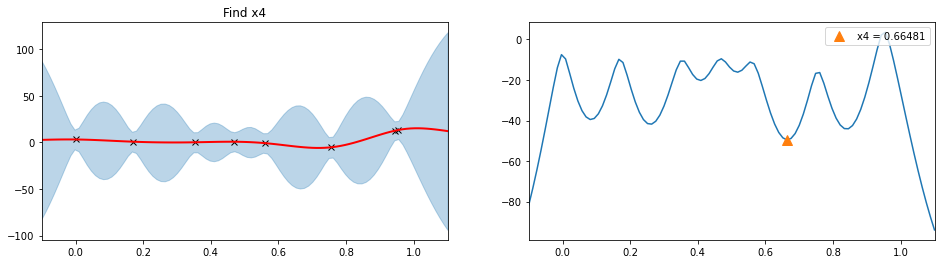

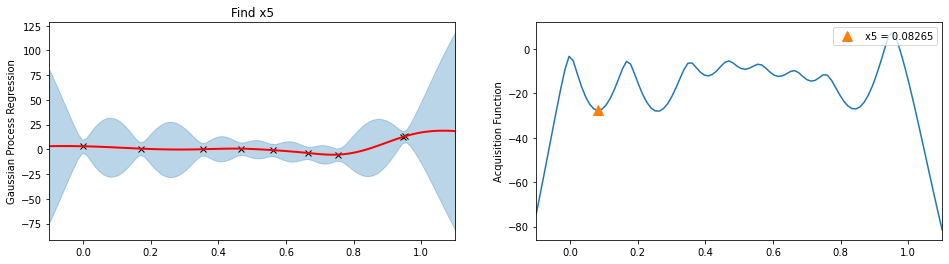

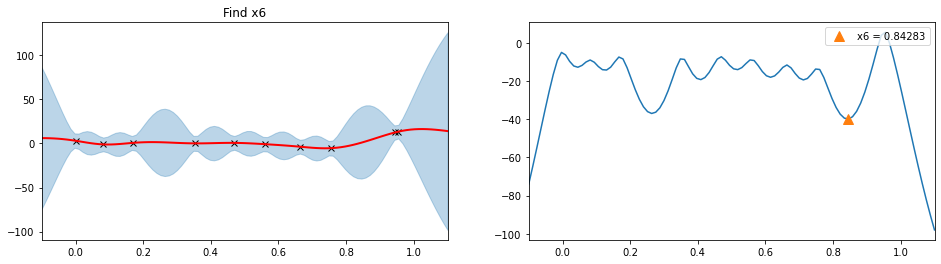

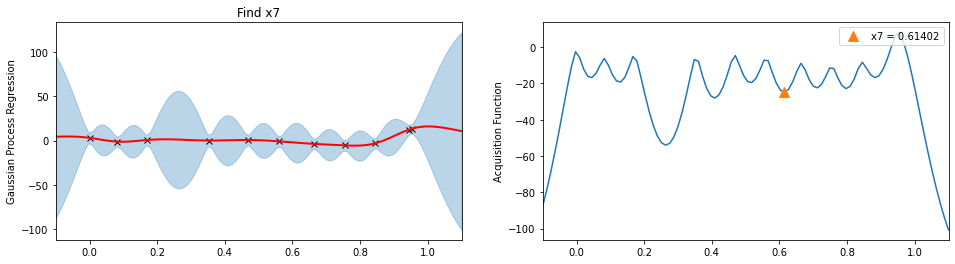

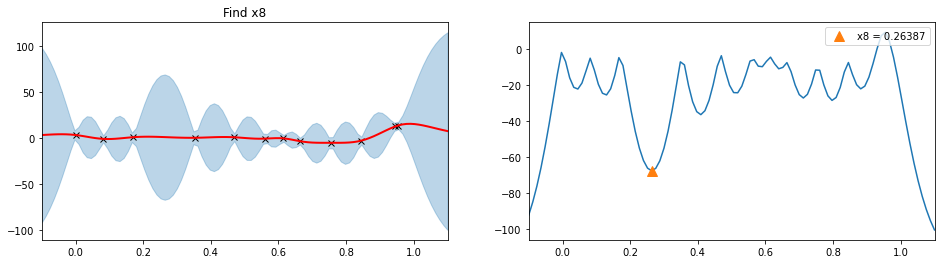

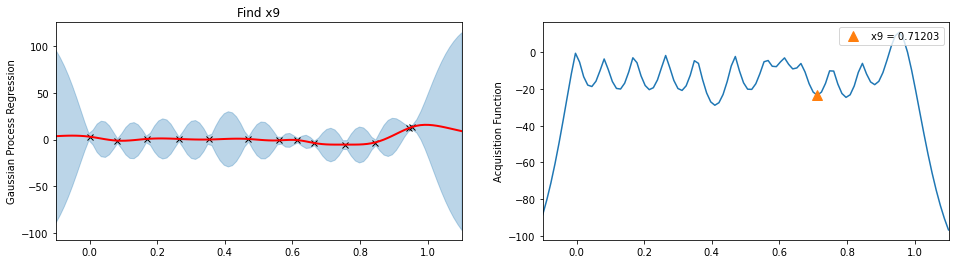

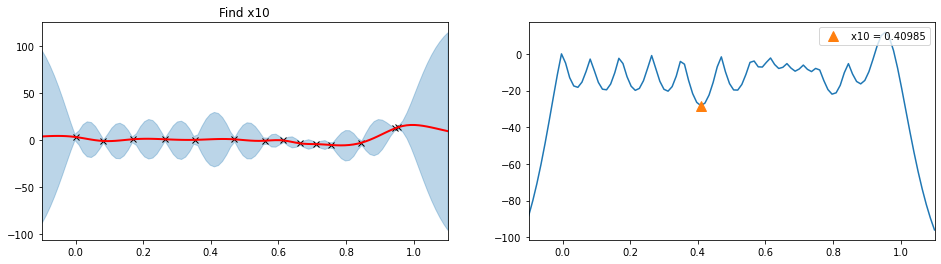

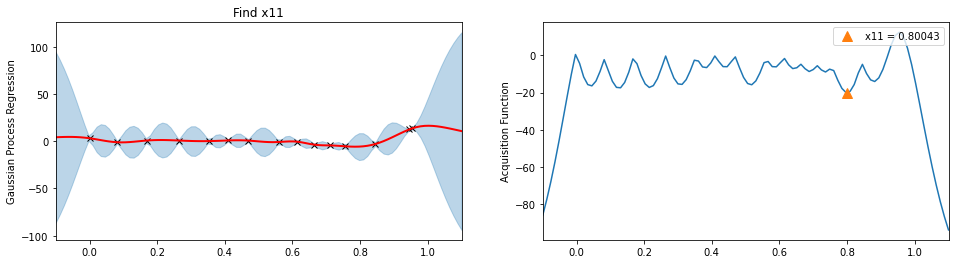

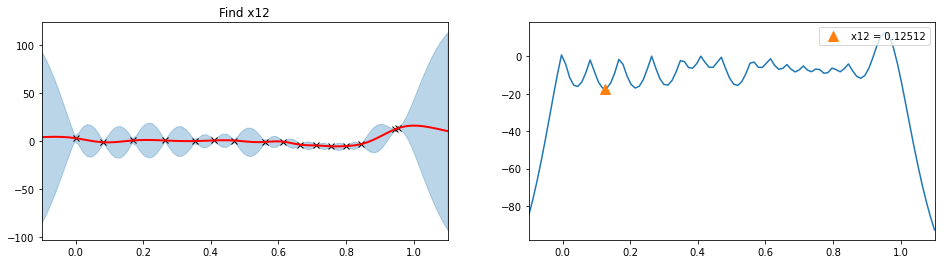

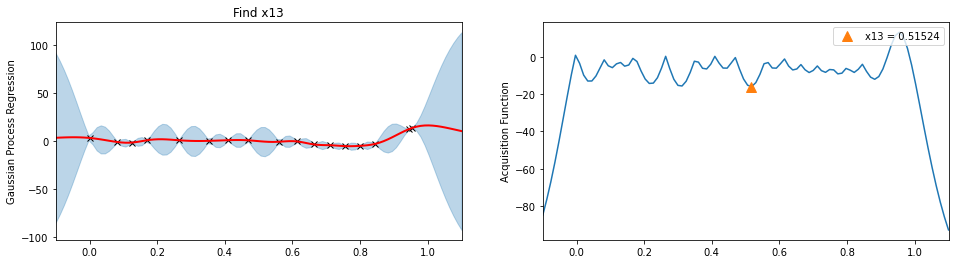

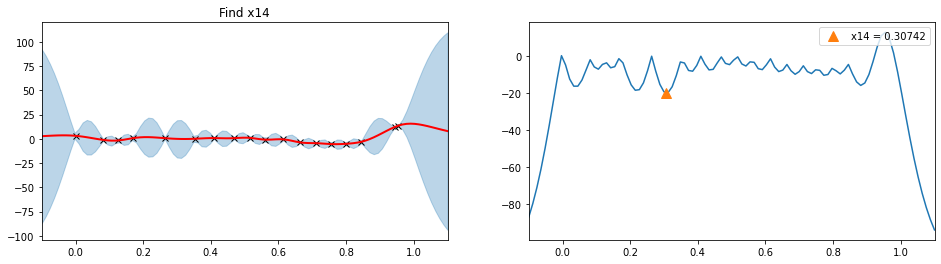

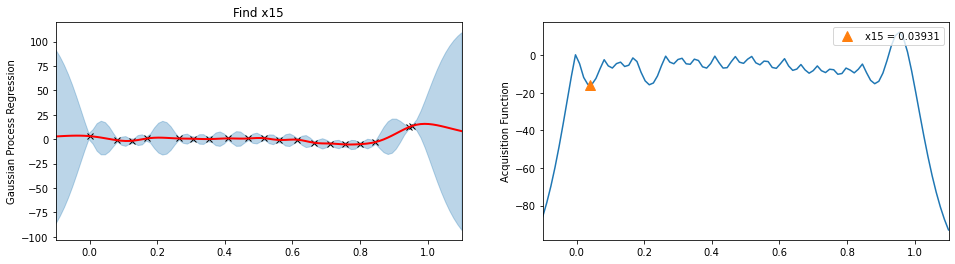

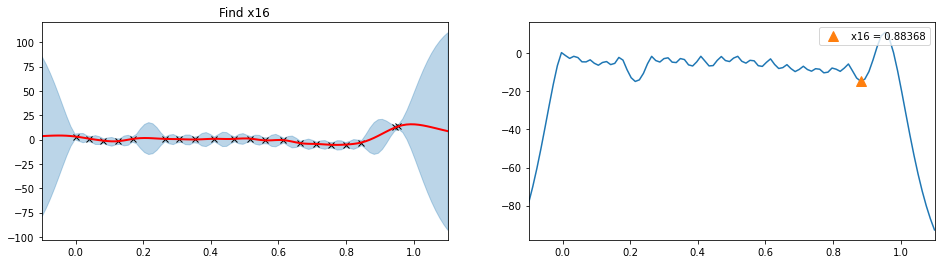

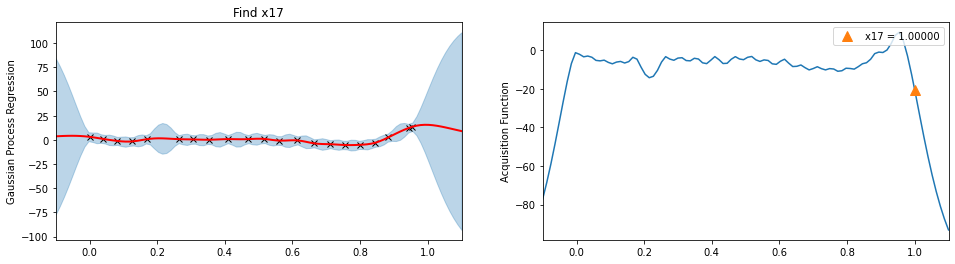

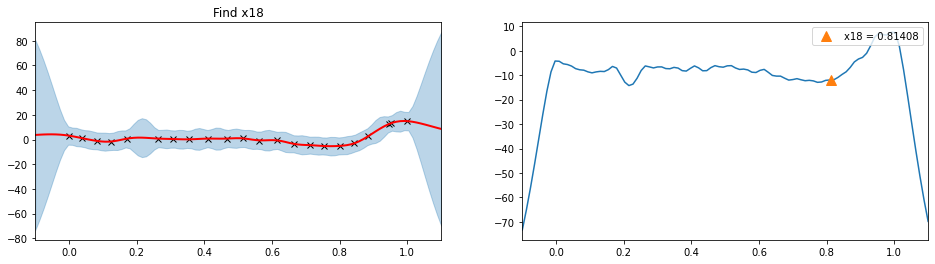

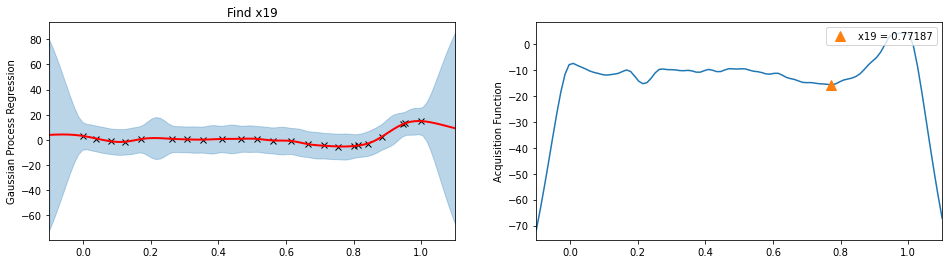

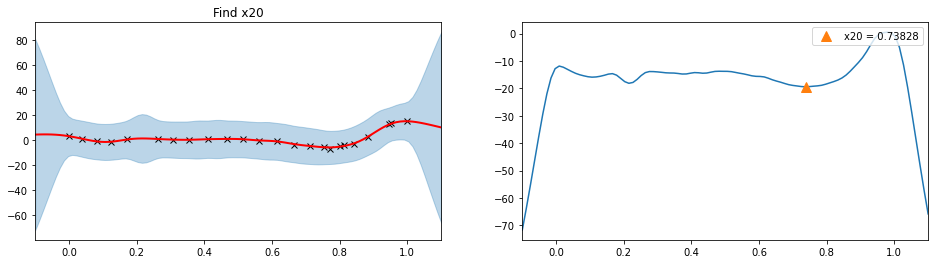

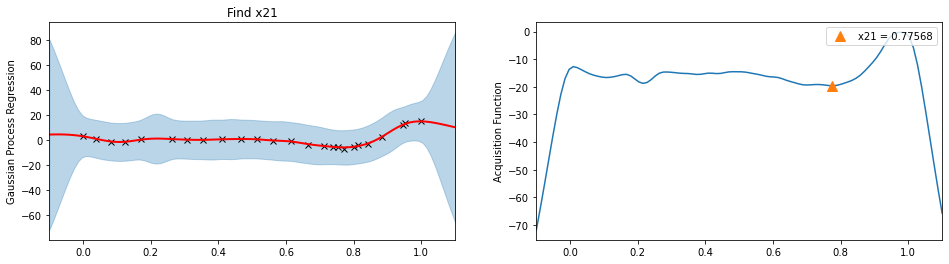

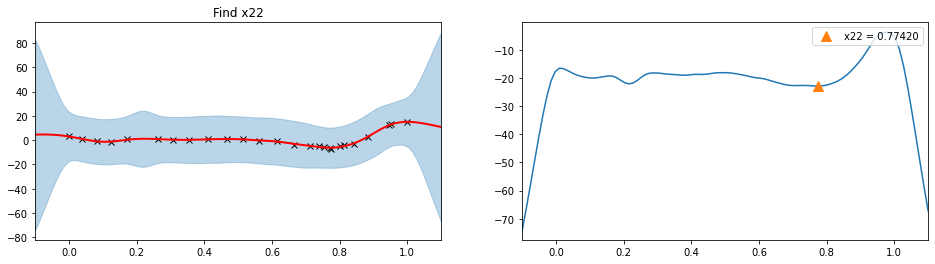

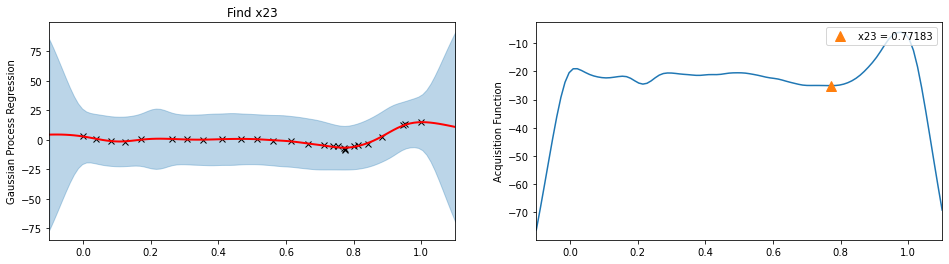

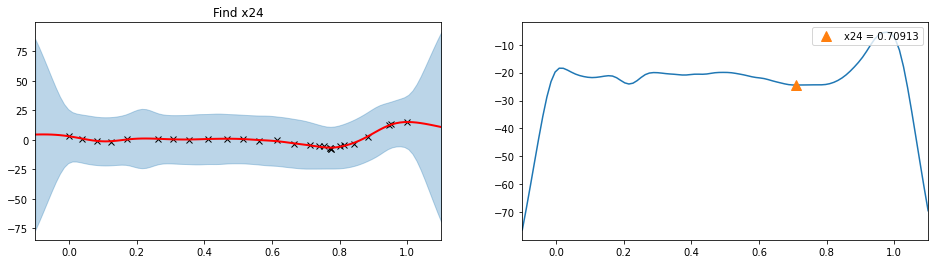

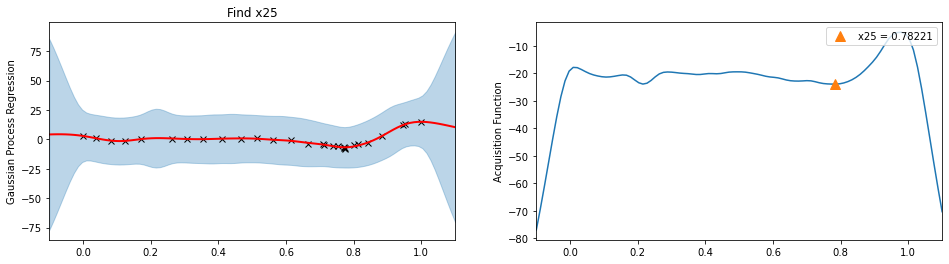

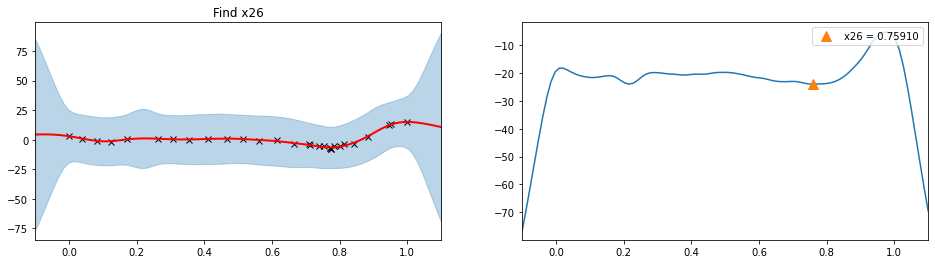

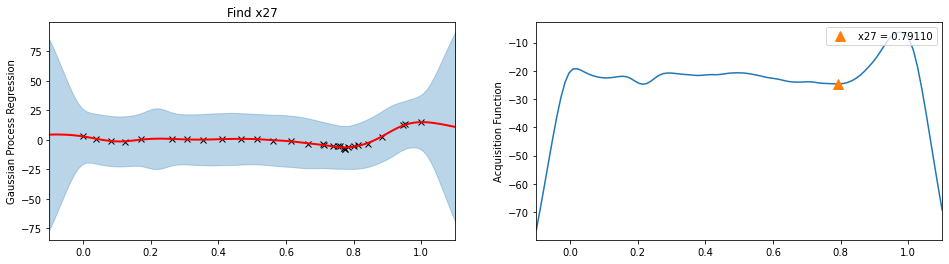

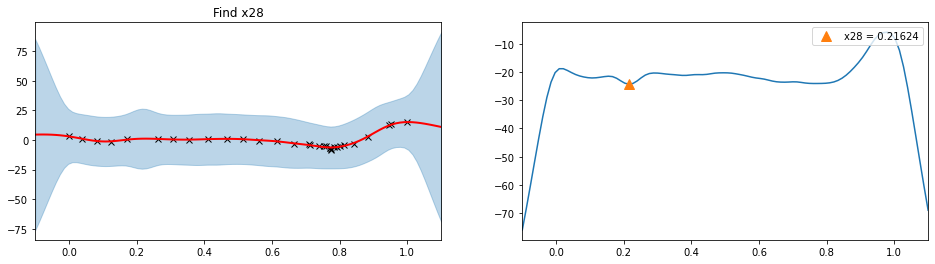

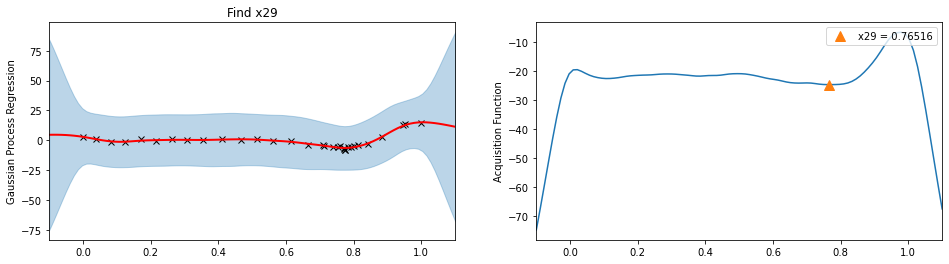

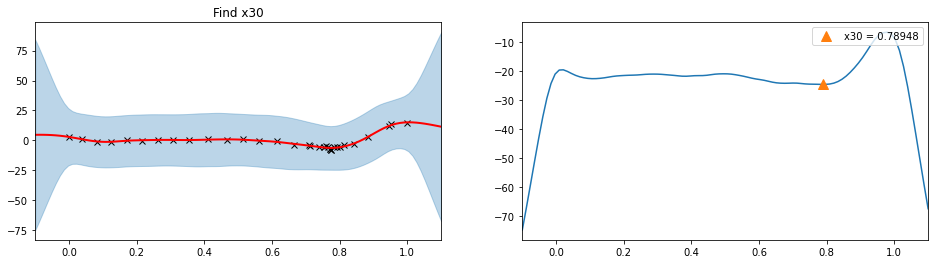

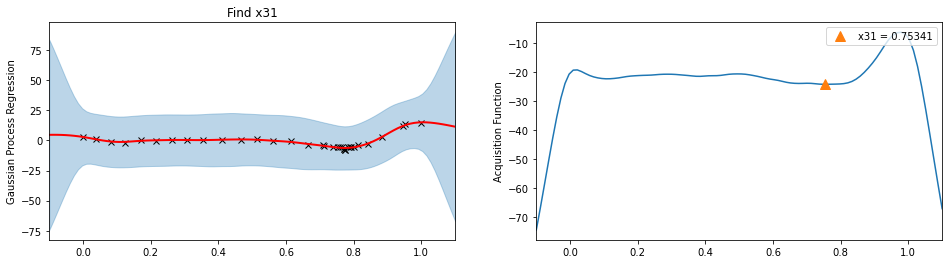

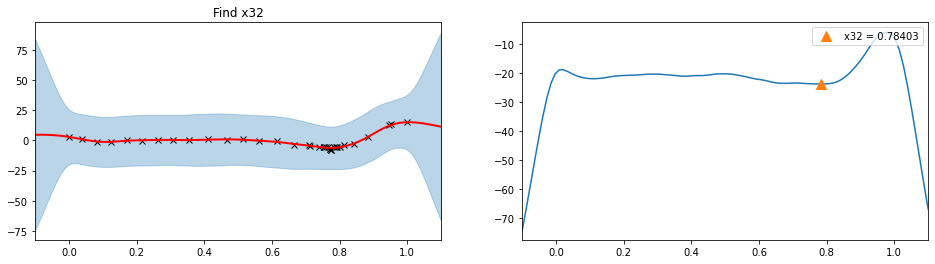

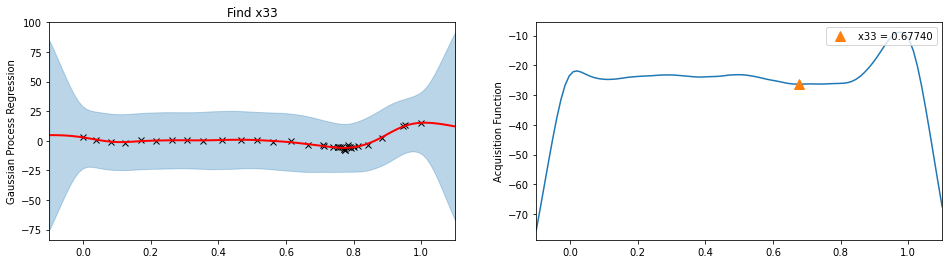

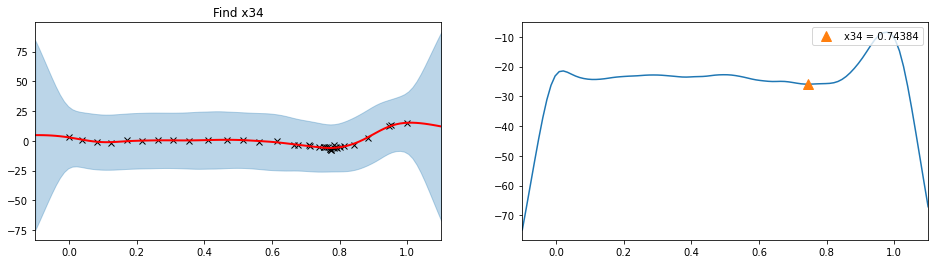

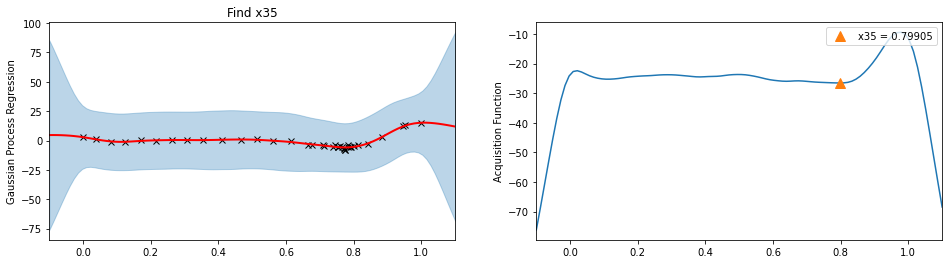

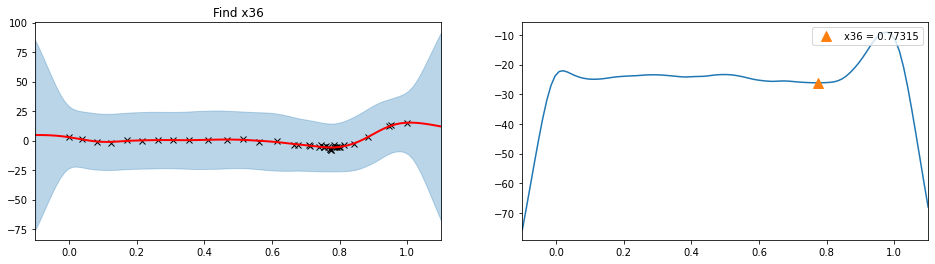

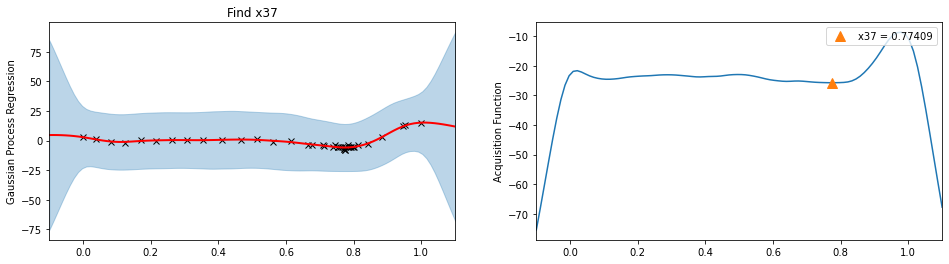

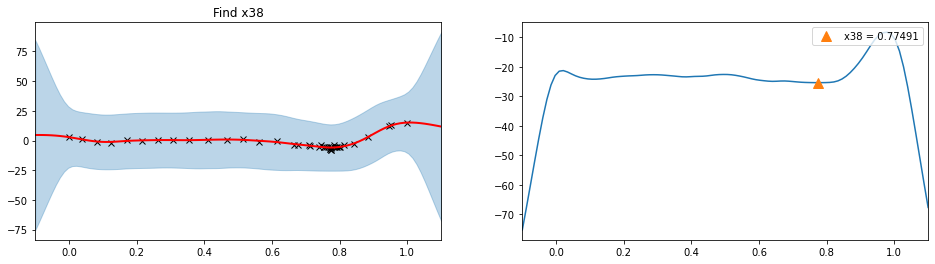

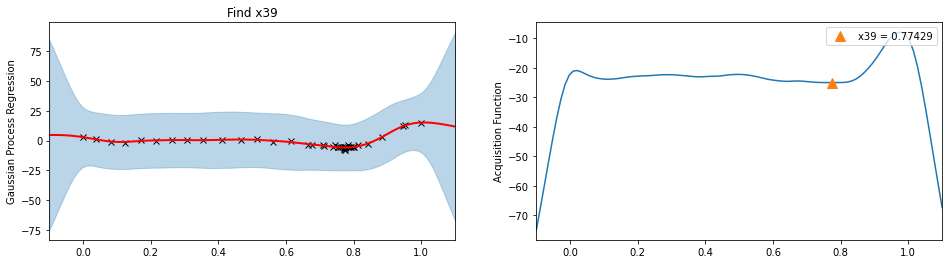

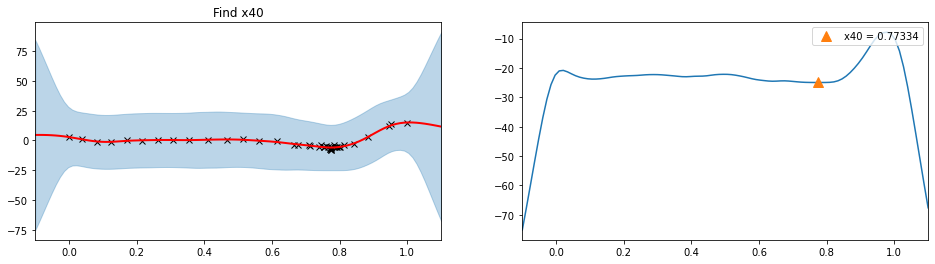

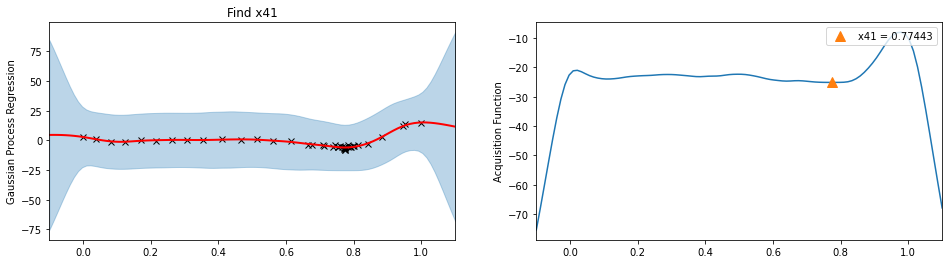

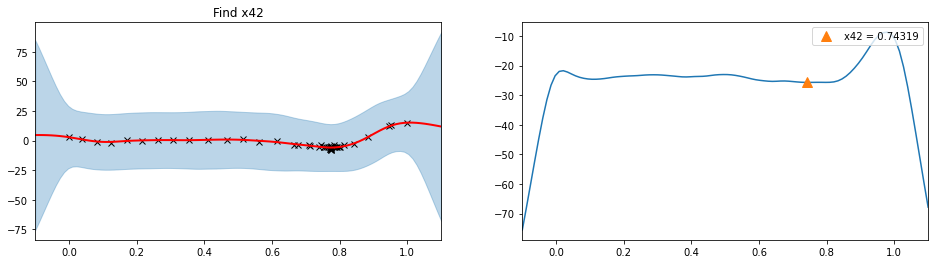

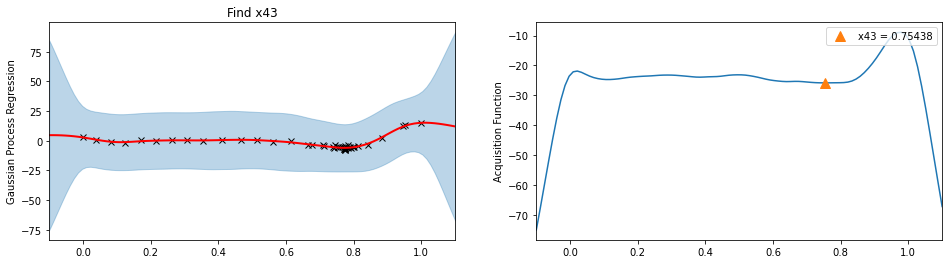

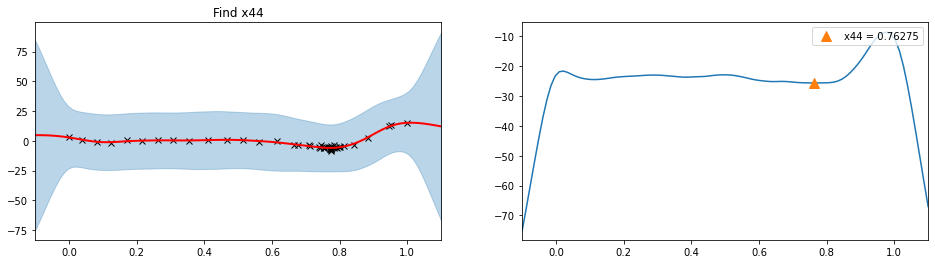

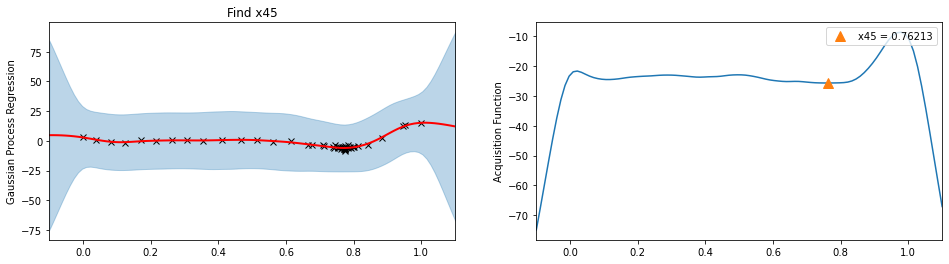

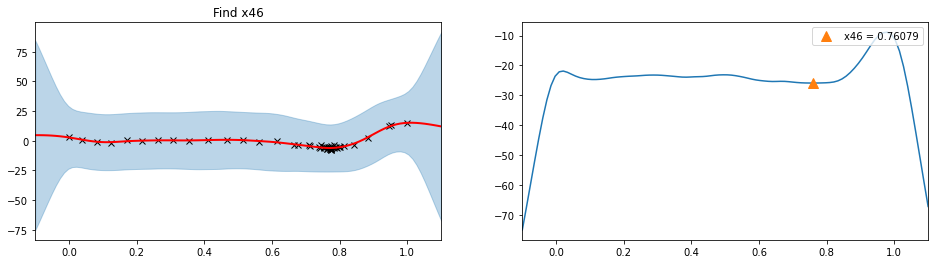

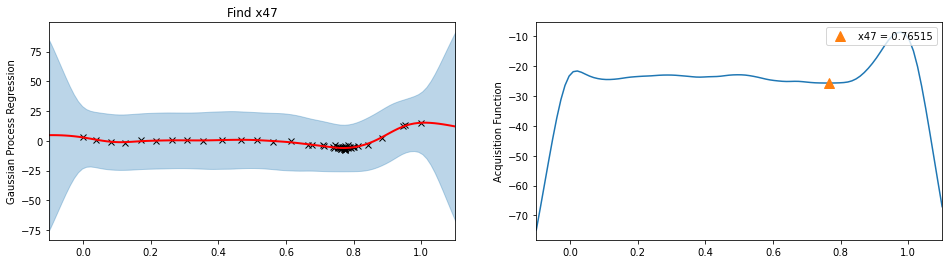

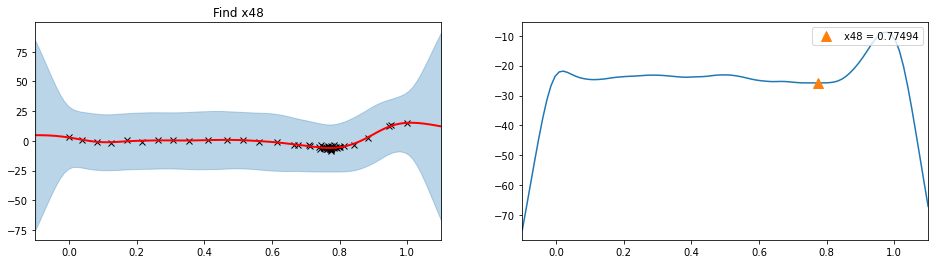

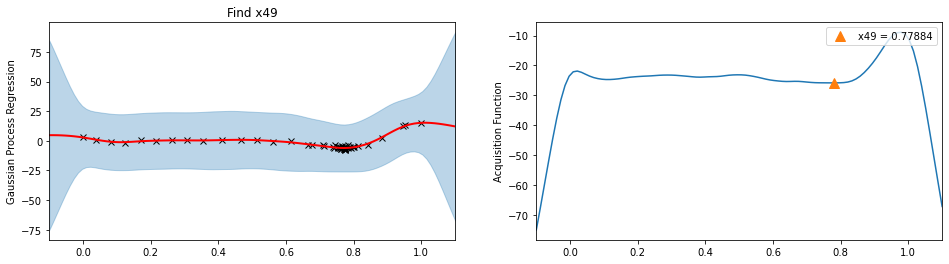

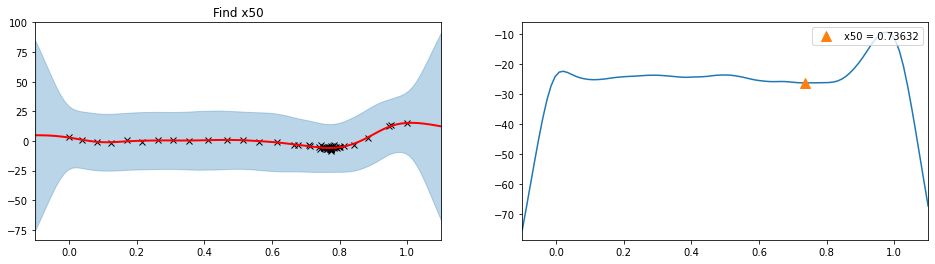

In [152]:
# plt.figure(figsize=(12, 30))
# outer_gs = gridspec.GridSpec(5, 2)
optimizer = torch.optim.Adam(gpmodel.parameters(), lr=0.001)
gp.util.train(gpmodel, optimizer)


for i in range(50):
    xmin = next_x()
#     gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer_gs[i])
    plot(xmin, xlabel=i+1, with_title=(i % 2 == 0))
    update_posterior(xmin)
    plt.show()

In [ ]:
## 

##  Pyro + GPyTorch

Performing inference with Pyro

**Pyro provides:**

- The engines for performing approximate inference or sampling
- The ability to define additional latent variables

**GPyTorch provides:**

- A library of kernels/means/likelihoods
- Mechanisms for efficient GP computations

**High level interface**

- Base class is gpytorch.models.PyroGP.
- GPyTorch automatically defines the model and guide functions for Pyro.
- Best used when prediction is the primary goal

**Low level interface**

- Base class is gpytorch.models.ApproximateGP.
- User defines the model and guide functions for Pyro.
- Best used when inference is the primary goal

## BoTorch Implementation 

### Intro

- BoTorch (pronounced like "blow-torch") is a library for Bayesian Optimization research built on top of PyTorch, and is part of the PyTorch ecosystem.

- BoTorch provides first-class support for state-of-the art probabilistic models in GPyTorch, a library for efficient and scalable GPs implemented in PyTorch 
    - support for multi-task GPs
    - deep kernel learning
    - deep GPs
    - approximate inference
 
 

In [54]:
import torch
from botorch.models import SingleTaskGP ,ModelListGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood

from botorch.models.gpytorch import GPyTorchModel
from gpytorch.distributions import MultivariateNormal
from gpytorch.means import ConstantMean
from gpytorch.models import ExactGP
from gpytorch.kernels import RBFKernel, ScaleKernel, MaternKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.priors import GammaPrior



### Show Objective function

In [42]:
def f(x):
    return (6 * x - 2)**2 * torch.sin(12 * x - 4)



In [43]:

x = torch.linspace(0, 1, 100)

# x_new = x.reshape((100, -1))
x_new = x.unsqueeze(1)

print(x.shape)
print(x_new.shape)


y = f(x)
y_noise = f(x) + torch.normal(0., 1, (x.shape[0],1)).view(-1)
# Show function with noise
print(y.shape)

fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=x, y=y,
                    mode='lines', line_color="#FE73FF",
                    name='fitted function'))
fig.add_trace(go.Scatter(x=x, y=y_noise,
                    mode='markers',
                    name='noisy data'))

fig.update_layout(title="Objective function", xaxis_title="input", yaxis_title = "output")
fig.show()




torch.Size([100])
torch.Size([100, 1])
torch.Size([100])


### Generate initial samples

In [129]:
torch.manual_seed(56)
#X = torch.tensor([0.0, 0.22, 0.56, 0.76, 1.0])
num_measurements = 5
x_train = torch.rand(num_measurements,1)
exact_obj = f(x_train)

# Get the function value with noise
noisy_obj = f(x_train)  + torch.normal(0., 1, (x_train.shape[0],1))
print('shape x_train:', x_train.shape)
print('shape exact_obj:', exact_obj.shape)
print('shape noisy_obj:', noisy_obj.shape)

shape x_train: torch.Size([5, 1])
shape exact_obj: torch.Size([5, 1])
shape noisy_obj: torch.Size([5, 1])


In [130]:
def generate_initial_data(n=5):
    x_train = torch.rand(n,1)
    exact_obj = f(x_train)

    # Get the function value with noise
    noisy_obj = f(x_train)  + torch.normal(0., 1, (x_train.shape[0],1))
    best_observed_value = exact_obj.min().item()
    return x_train, noisy_obj, best_observed_value
    

### Fit a Gaussian Process model to data

In [131]:
num_measurements = 5
init_x,  init_y, best_init_y = generate_initial_data(num_measurements )

# one imput variable
bounds = torch.tensor([[0.], [5.0]])
                       
# 2 imputs
#bounds = torch.tensor([[0., 1.0], [5.0, 5.0]])


single_model =  SingleTaskGP(init_x,  init_y)
mll = ExactMarginalLogLikelihood(single_model.likelihood, single_model)
fit_gpytorch_model(mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
        (distance_module): Distance()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
  )
)

### Construct an acquisition function

In [132]:
from botorch.acquisition import UpperConfidenceBound 
from botorch.acquisition.monte_carlo import qExpectedImprovement

UCB = UpperConfidenceBound(single_model, beta=0.2)

# if no Noise 
# EI = qExpectedImprovement(model=single_model,best_f= best_init_y)

###  Optimize the acquisition function

In [133]:
from botorch.optim import optimize_acqf

# bounds = torch.stack([torch.zeros(1), torch.ones(1)])
bounds = torch.tensor([[0.], [1.0]])
candidates, acq_value = optimize_acqf(
    acq_function=UCB, 
    bounds=bounds, 
    q=1, 
    num_restarts=20, 
    raw_samples=100,
    options={"batch_limit":5, "maxiter":200}
)
candidates

tensor([[0.6651]])

### Optimization Loop

In [153]:
def get_next_points(init_x,  init_y, best_init_y, bounds, n_points=1):
    single_model =  SingleTaskGP(init_x,  init_y)
    mll = ExactMarginalLogLikelihood(single_model.likelihood, single_model)
    fit_gpytorch_model(mll)
    
    UCB = UpperConfidenceBound(single_model, beta=0.2)
    candidates, acq_value = optimize_acqf(
    acq_function=UCB, 
    bounds=bounds, 
    q=n_points, 
    num_restarts=20, 
    raw_samples=100,
    options={"batch_limit":5, "maxiter":200})
    
    return candidates

In [154]:
bounds = torch.tensor([[0.], [1.0]])
get_next_points(init_x,  init_y, best_init_y, bounds, n_points=1)

(tensor([[0.4830]]), tensor(0.7272))

In [137]:
new_candidates = get_next_points(init_x,  init_y, best_init_y, bounds, n_points=1)
new_candidates 

tensor([[0.6651]])

In [138]:
new_results = f(new_candidates)  + torch.normal(0., 1, (new_candidates.shape[0],1))
new_results

tensor([[-2.1021]])

In [139]:
n_runs = 10
init_x,  init_y, best_init_y = generate_initial_data(num_measurements )
bounds = torch.tensor([[0.], [1.0]])

for i in range(n_runs):
    print(f"Nr. of optimization run: {i}")
    new_candidates = get_next_points(init_x,  init_y, best_init_y, bounds, n_points=1)
    new_results = f(new_candidates)  + torch.normal(0., 1, (new_candidates.shape[0],1))
    
    print(f"New candidates are:{new_candidates}")
    init_x = torch.cat([init_x, new_candidates])
    init_y = torch.cat([init_y, new_results])
    
    best_init_y = init_y.min().item()
    print(f"Best point performs this way:{best_init_y }")

Nr. of optimization run: 0
New candidates are:tensor([[0.3962]])
Best point performs this way:-4.604670524597168
Nr. of optimization run: 1
New candidates are:tensor([[0.2798]])
Best point performs this way:-4.604670524597168
Nr. of optimization run: 2
New candidates are:tensor([[0.4009]])
Best point performs this way:-4.604670524597168
Nr. of optimization run: 3
New candidates are:tensor([[0.4060]])
Best point performs this way:-4.604670524597168
Nr. of optimization run: 4
New candidates are:tensor([[0.3502]])
Best point performs this way:-4.604670524597168
Nr. of optimization run: 5
New candidates are:tensor([[0.4316]])
Best point performs this way:-4.604670524597168
Nr. of optimization run: 6
New candidates are:tensor([[0.4504]])
Best point performs this way:-4.604670524597168
Nr. of optimization run: 7
New candidates are:tensor([[0.4746]])
Best point performs this way:-4.604670524597168
Nr. of optimization run: 8
New candidates are:tensor([[0.4787]])
Best point performs this way:-4

In [ ]:
def plot(new_candidates, xlabel=None, with_title=True, k=20):
    plt.figure(figsize = (16,4))
    plt.subplot(1,2,1)
    xlabel = "xmin" if xlabel is None else "x{}".format(xlabel)
    Xnew = torch.linspace(-0.1, 1.1)
    y = f(Xnew)
#     ax1 = plt.subplot(gs[0])
    plt.plot(gpmodel.X.numpy(), y.numpy(), "kx")  # plot all observed data
    with torch.no_grad():
        loc, var = gpmodel(Xnew, full_cov=False, noiseless=False)
        sd = var.sqrt()
        plt.plot(Xnew.numpy(), loc.numpy(), "r", lw=2)  # plot predictive mean
        plt.fill_between(Xnew.numpy(), loc.numpy() - k*sd.numpy(), loc.numpy() + k*sd.numpy(),
                         color="C0", alpha=0.3)  # plot uncertainty intervals
    plt.xlim(-0.1, 1.1)
    plt.title("Find {}".format(xlabel))
    if with_title:
        plt.ylabel("Gaussian Process Regression")

#     ax2 = plt.subplot(gs[1])
    plt.subplot(1,2,2)
    with torch.no_grad():
        # plot the acquisition function
        plt.plot(Xnew.numpy(), lower_confidence_bound(Xnew).numpy())
        # plot the new candidate point
        plt.plot(xmin.numpy(), lower_confidence_bound(xmin).numpy(), "^", markersize=10,
                 label="{} = {:.5f}".format(xlabel, xmin.item()))
    plt.xlim(-0.1, 1.1)
    if with_title:
        plt.ylabel("Acquisition Function")
    plt.legend(loc=1)

### Outro 

In [ ]:
n_runs = 10
init_x,  init_y, best_init_y = generate_initial_data(num_measurements )
bounds = torch.tensor([[0.], [1.0]])

Xnew = torch.linspace(-0.1, 1.1)

for i in range(n_runs):
    print(f"Nr. of optimization run: {i}")
    new_candidates = get_next_points(init_x,  init_y, best_init_y, bounds, n_points=1)
    new_results = f(new_candidates)  + torch.normal(0., 1, (new_candidates.shape[0],1))
    
    print(f"New candidates are:{new_candidates}")
    init_x = torch.cat([init_x, new_candidates])
    init_y = torch.cat([init_y, new_results])
    
    best_init_y = init_y.min().item()
    print(f"Best point performs this way:{best_init_y }")

    plt.plot(gpmodel.X.numpy(), gpmodel.y.numpy(), "kx")  # plot all observed data
    with torch.no_grad():
        loc, var = gpmodel(Xnew, full_cov=False, noiseless=False)
        sd = var.sqrt()
        plt.plot(Xnew.numpy(), loc.numpy(), "r", lw=2)  # plot predictive mean
        plt.fill_between(Xnew.numpy(), loc.numpy() - k*sd.numpy(), loc.numpy() + k*sd.numpy(),
                         color="C0", alpha=0.3)  # plot uncertainty intervals
    plt.xlim(-0.1, 1.1)
    plt.title("Find {}".format(xlabel))
    if with_title:
        plt.ylabel("Gaussian Process Regression")

#     ax2 = plt.subplot(gs[1])
    plt.subplot(1,2,2)
    with torch.no_grad():
        # plot the acquisition function
        plt.plot(Xnew.numpy(), lower_confidence_bound(Xnew).numpy())
        # plot the new candidate point
        plt.plot(xmin.numpy(), lower_confidence_bound(xmin).numpy(), "^", markersize=10,
                 label="{} = {:.5f}".format(xlabel, xmin.item()))
    plt.xlim(-0.1, 1.1)
    if with_title:
        plt.ylabel("Acquisition Function")
    plt.legend(loc=1)

## Gpy Implementation

GPy  Gaussian processes framework in Python.


1. Fit a GP to the data
2. Identify the GP mean
3. Find the minimum of the GP mean

In [167]:
import numpy as np 
np.random.seed(33)
f = lambda xi: (6 * xi - 2)**2 * np.sin(12 * xi - 4)
# sampling space
N = 100
X_grid = np.linspace(0, 1, N)[:,None]
Y_grid = f(X_grid)
Y_grid.shape

(100, 1)

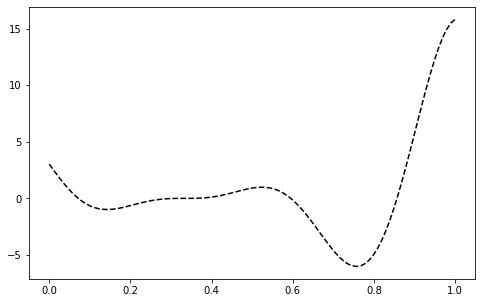

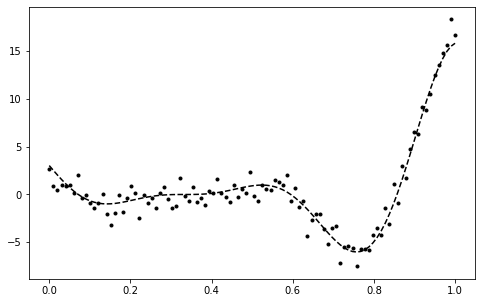

In [168]:


# Show function
FIGSIZE = (8, 5)
plt.figure(figsize=FIGSIZE)
plt.plot(X_grid, Y_grid,'k--')

# Show function with noise
plt.figure(figsize=FIGSIZE)
plt.plot(X_grid, Y_grid,'k--')
plt.plot(X_grid, Y_grid + np.random.normal(0., 1, X_grid.shape) ,'k.')

### Lets sample 5 data points and fit a GP to the data.

In [169]:
def plot_gp(X, m, C, training_points=None):
    """ Plotting utility to plot a GP fit with 95% confidence interval """
    # Plot 95% confidence interval 
    plt.fill_between(X[:,0],
                     m[:,0] - 1.96*np.sqrt(np.diag(C)),
                     m[:,0] + 1.96*np.sqrt(np.diag(C)),
                     alpha=0.5)
    # Plot GP mean and initial training points
    plt.plot(X, m, "-")
    
    plt.xlabel("x"), plt.ylabel("f")
    
    # Plot training points if included
    if training_points is not None:
        X_, Y_ = training_points
        plt.plot(X_, Y_, "kx", mew=2)


Name : GP regression
Objective : 15.305452844420218
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  Mat52.variance           |    85.19558381225686  |      +ve      |        
  Mat52.lengthscale        |  0.15037286424546287  |      +ve      |        
  Gaussian_noise.variance  |   0.8422800856718922  |      +ve      |        


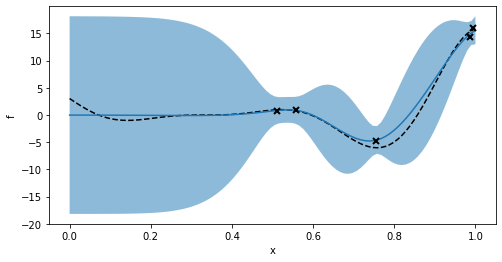

In [170]:
# we sample the function and look at GP prediction
# Sample from the function
# Number of samples 
num_measurements = 5

# Random sample locations
X_samples =  np.random.uniform(0., 1.0,(num_measurements, 1))



# Get the function value with noise
Y_samples = f(X_samples)+ np.random.normal(0., 1, (X_samples.shape[0],1))

# Set up the kernel and the GP model
k = GPy.kern.Matern52(1)
m = GPy.models.GPRegression(X_samples, Y_samples, k)

# optimize hyperparameters
m.optimize('bfgs', max_iters=100)
    
# Identify the mean and covariance of the GP fit over the grid
mean, Cov = m.predict(X_grid, full_cov=True)

# Plot the generating curve and the GP
plt.figure(figsize = (8,4))
plt.plot(X_grid, Y_grid,'k--')
plot_gp(X_grid, mean, Cov, training_points=(X_samples,Y_samples))
print(m)

 ### sample the GP given our measured data points:

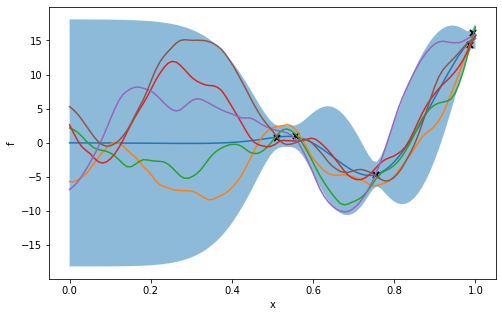

In [171]:
mean, Cov = m.predict_noiseless(X_grid, full_cov=True)
Z  = np.random.multivariate_normal(mean.ravel(), Cov, 5).T
plt.figure(figsize = FIGSIZE)
plot_gp(X_grid, mean, Cov, training_points=(X_samples,Y_samples))
plt.plot(X_grid,Z);

### The model

In [175]:
# We're going to use the GP in the same way multiple times, so let's create a function
def GP_analysis(X, Y, X_grid):
    # Use GP regression to fit the data
    k = GPy.kern.Matern52(1)
    m = GPy.models.GPRegression(X, Y, k)
    m.optimize('bfgs', max_iters=100)
    
    # Predict the mean and covariance of the GP fit over the grid
    mean, Cov = m.predict(X_grid, full_cov=True)
    variance = np.diag(Cov)
    return mean, Cov, variance, m


In [190]:
# We will also plot the Bayesian Optimization results multiple times, so let's create a function too:
def plot_BO_results(X_grid, Y_grid, mean, Cov, alpha_full, X_samples, Y_samples, next_sample, true_min_x, true_min_y,xlabel=None):
    xlabel = "xmin" if xlabel is None else "x{}".format(xlabel)
    plt.figure(figsize = (16,4))
    plt.subplot(1,2,1)
    plt.plot(X_grid, Y_grid,'k--')
    plot_gp(X_grid, mean, Cov, training_points=(X_samples,Y_samples))
    plt.plot([X_grid[next_sample], X_grid[next_sample]],[-1.5, 1.5],'m')
    plt.plot(true_min_x, true_min_y, 'ro')
    plt.title("Find {}".format(xlabel))
        
    plt.subplot(1,2,2)
    plt.plot(X_grid, alpha_full,'r')
    plt.plot([X_grid[next_sample], X_grid[next_sample]],[0, np.min(alpha_full)],'m',label="{} = {:.5f}".format(xlabel, np.min(X_grid[next_sample])))
    plt.title('Aquisition function')
    plt.legend()

### Loop of Bayesian Optimization

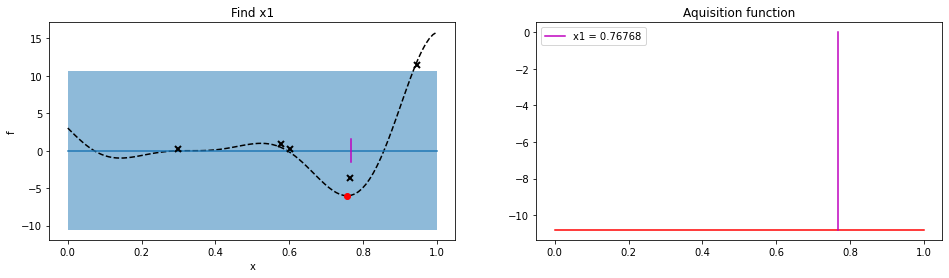

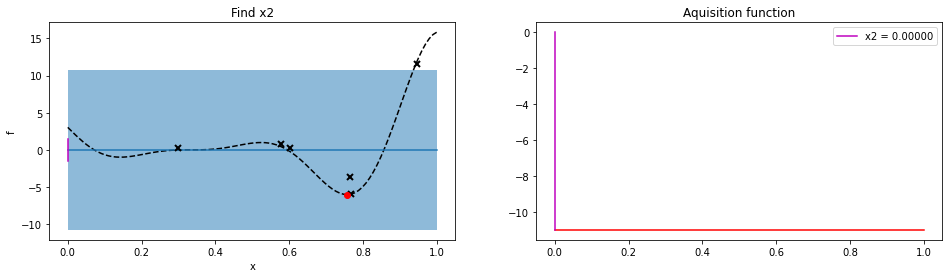

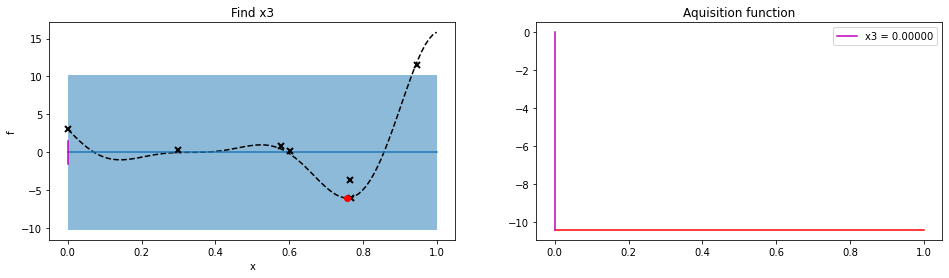

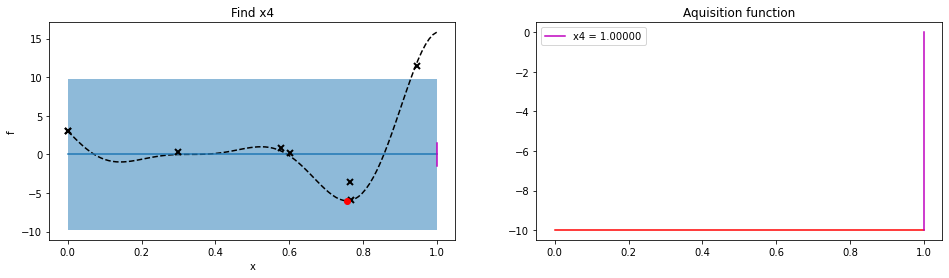

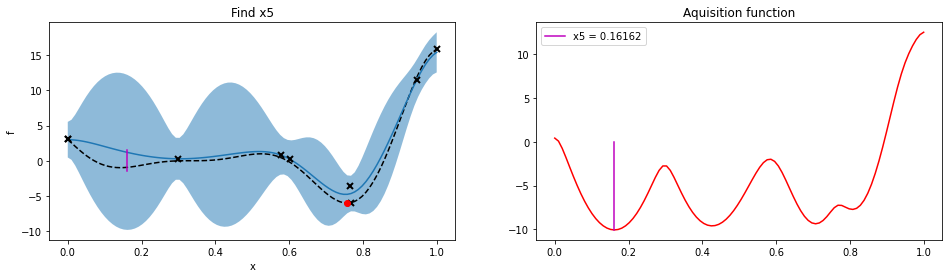

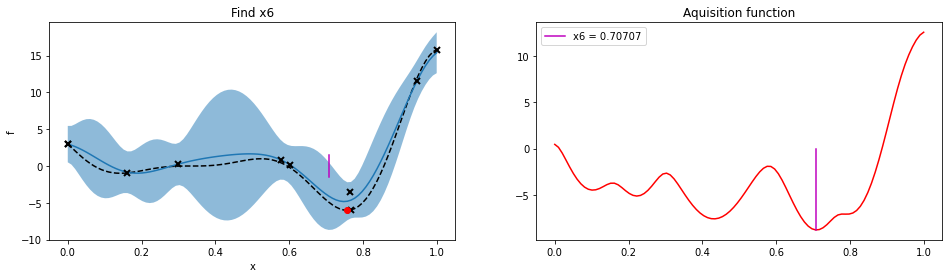

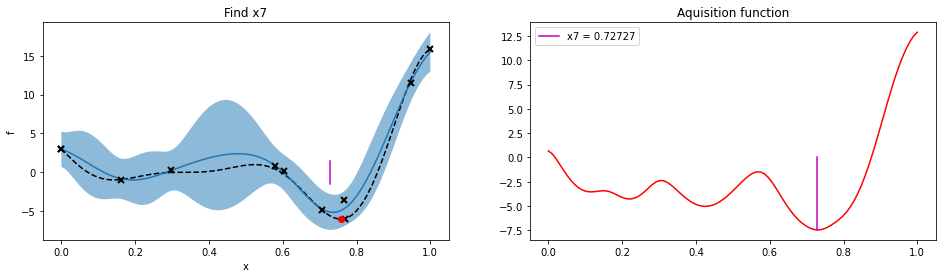

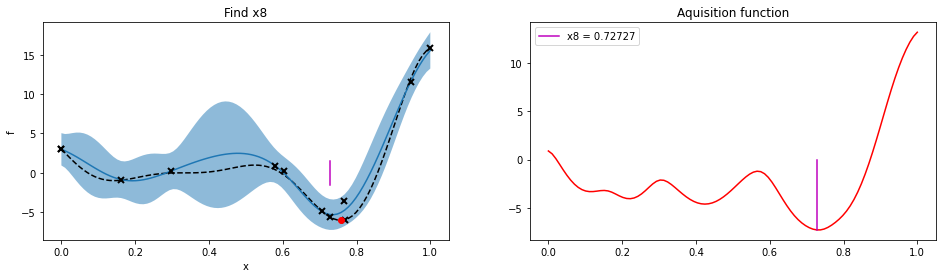

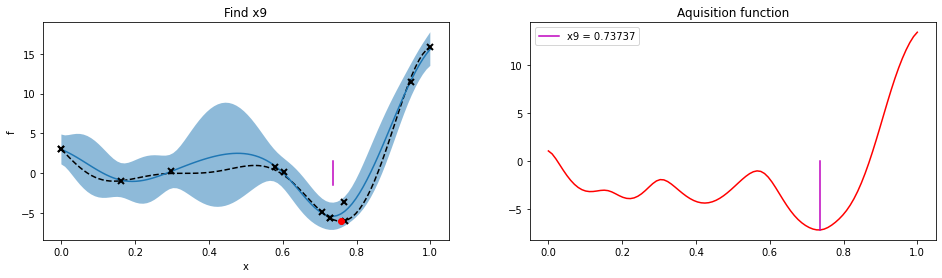

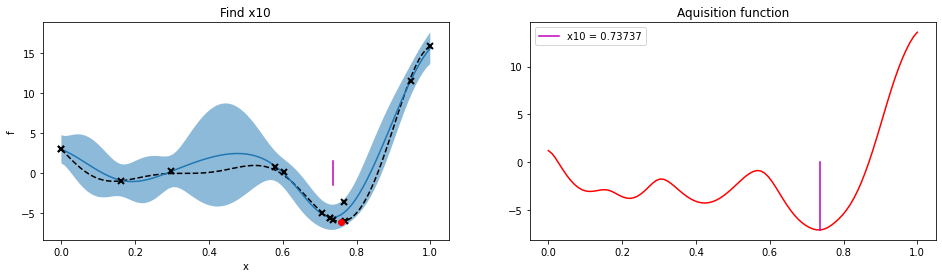

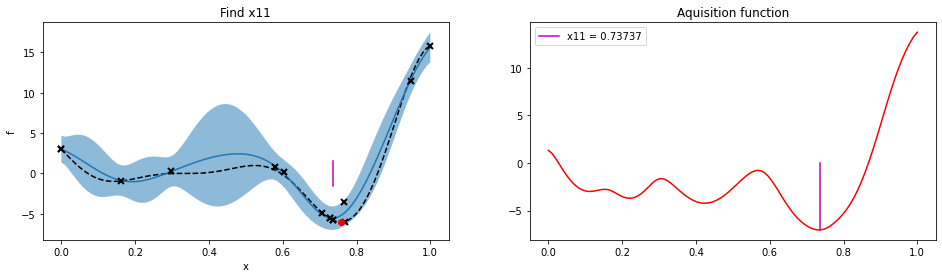

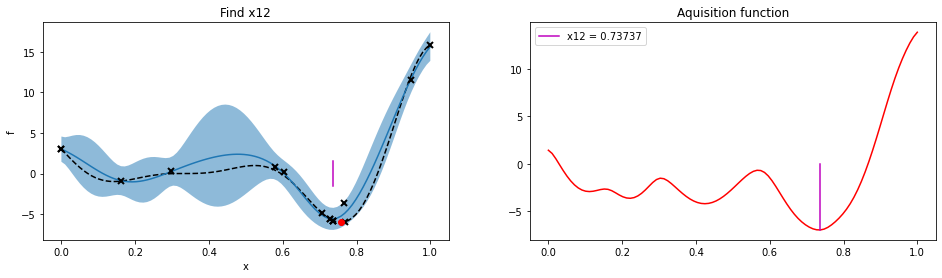

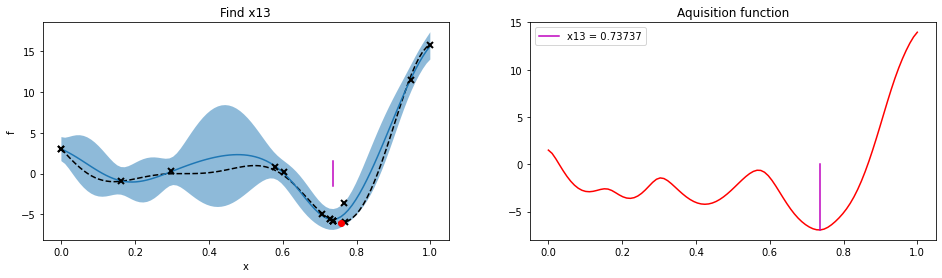

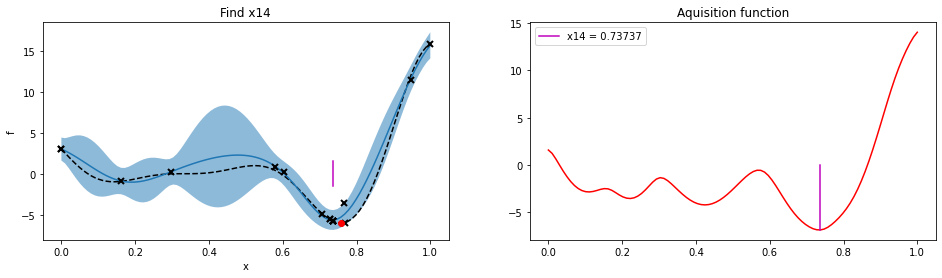

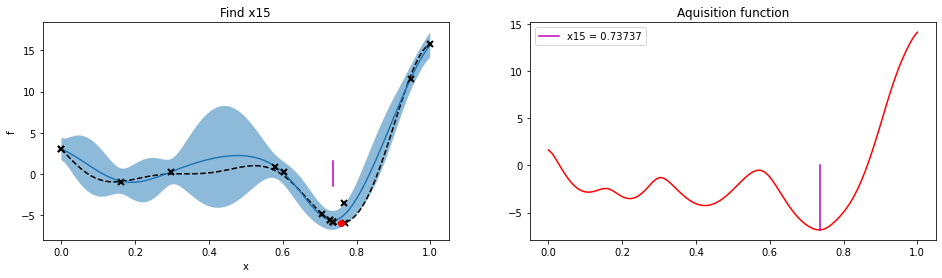

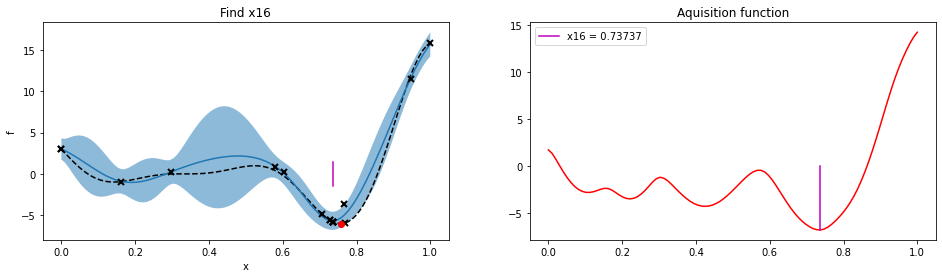

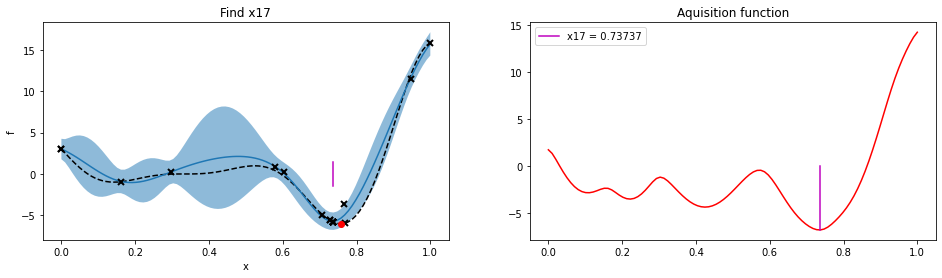

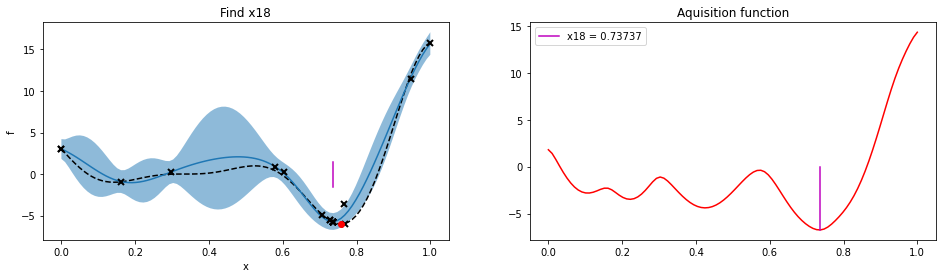

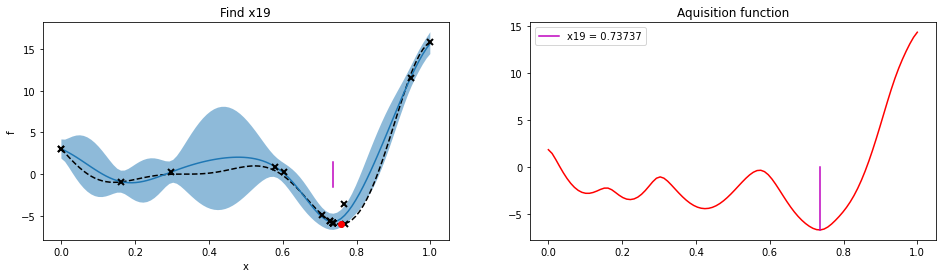

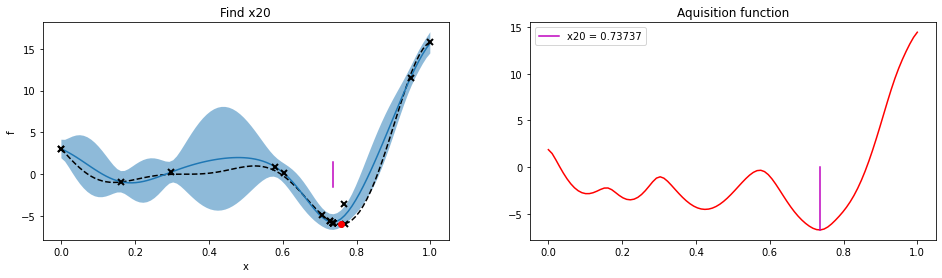

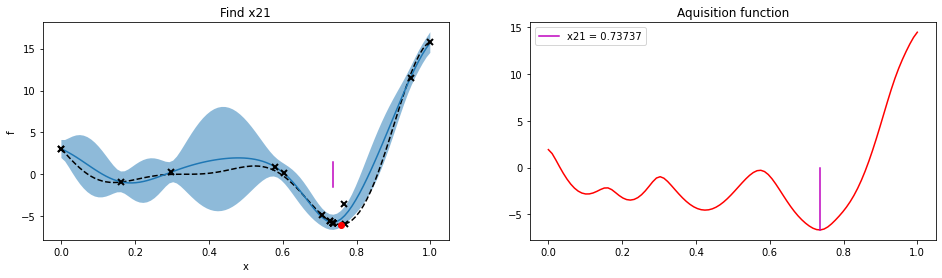

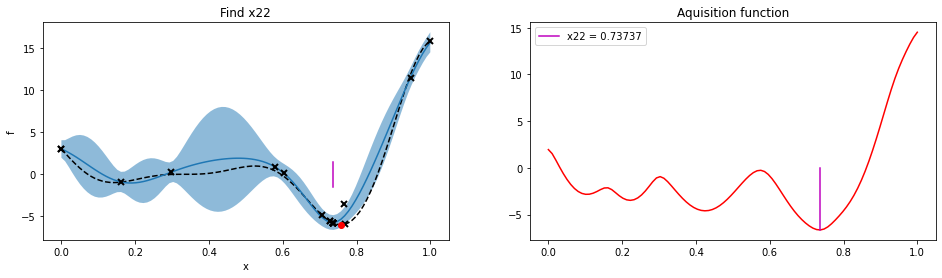

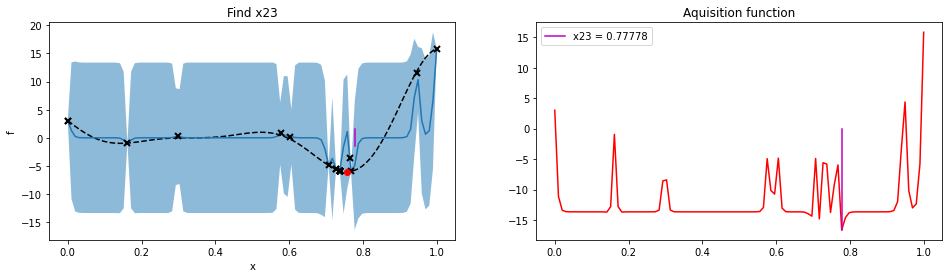

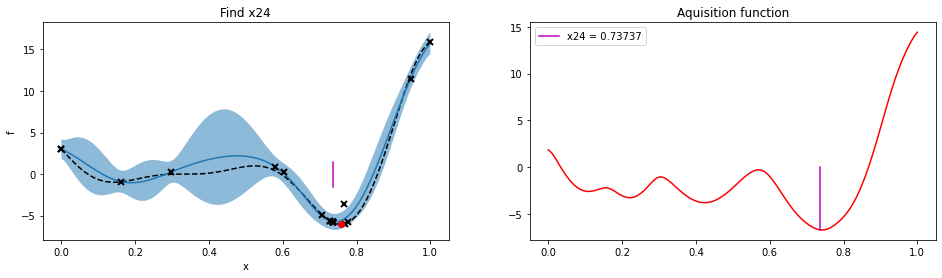

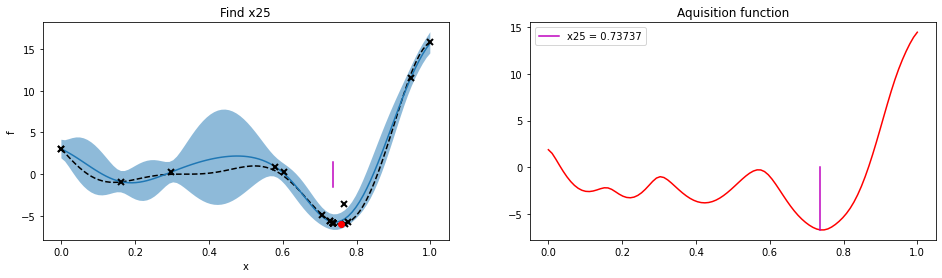

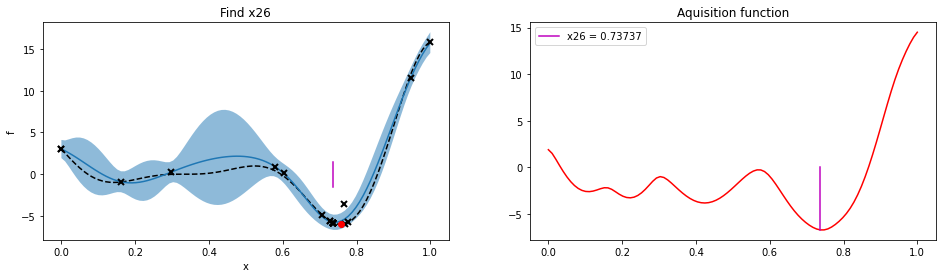

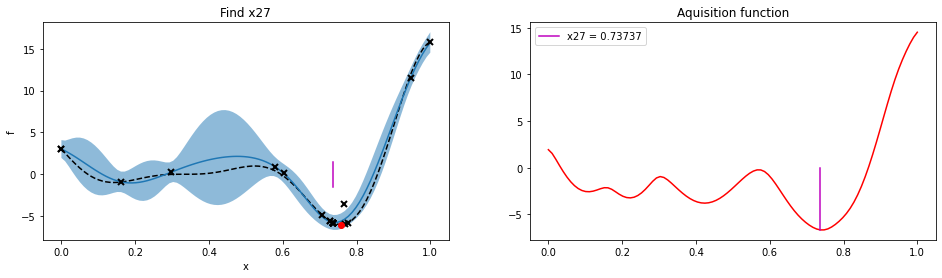

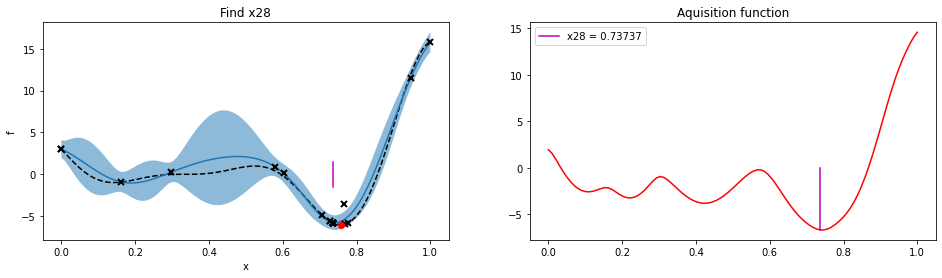

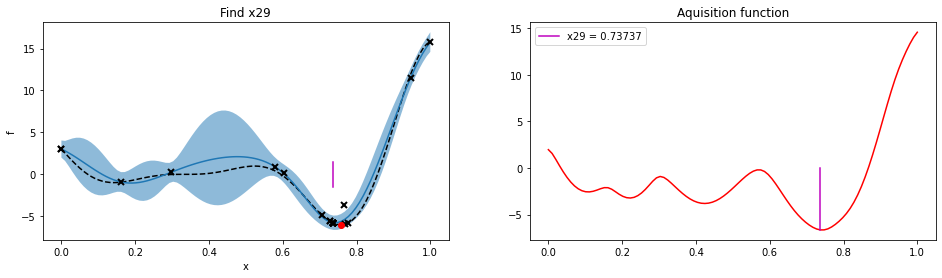

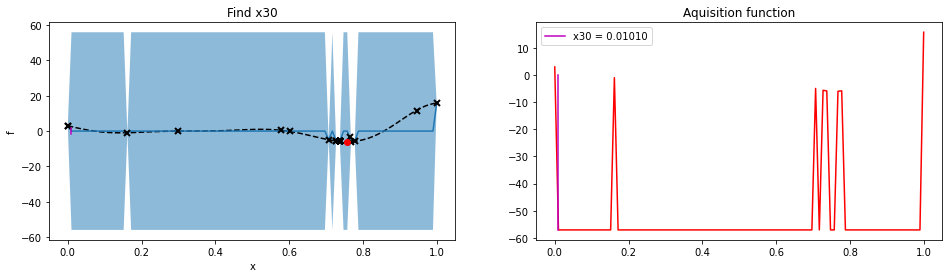

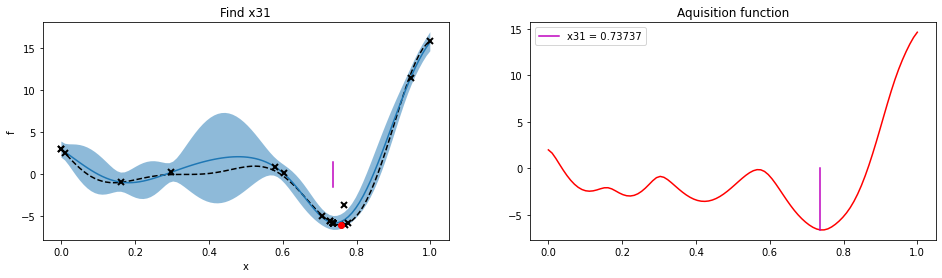

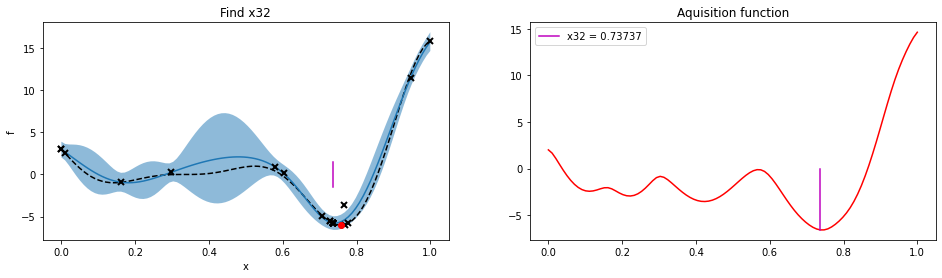

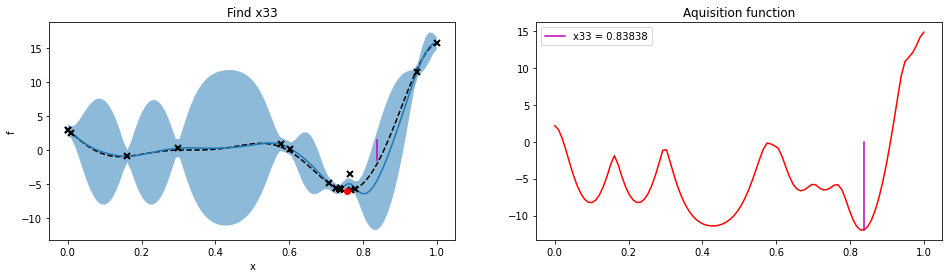

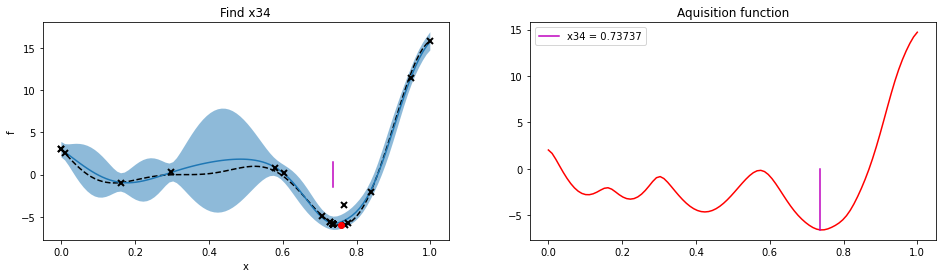

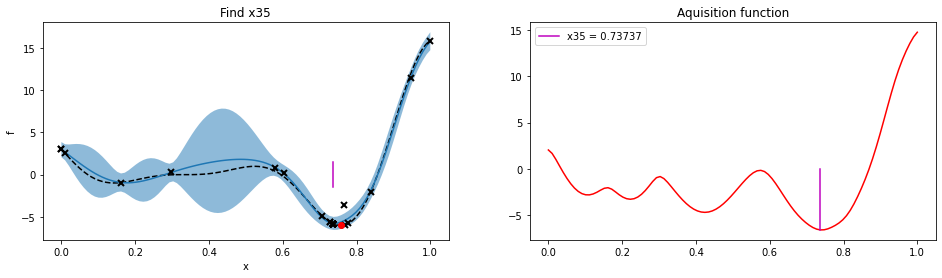

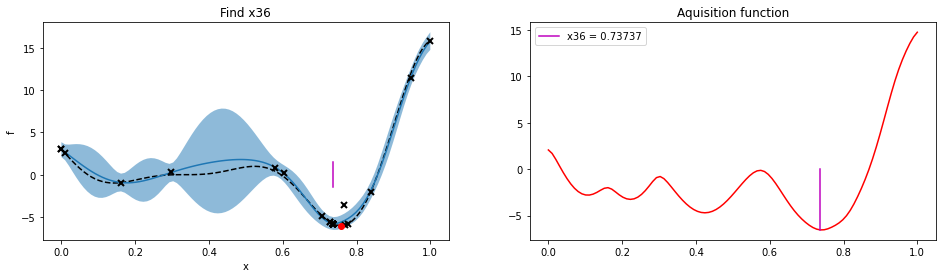

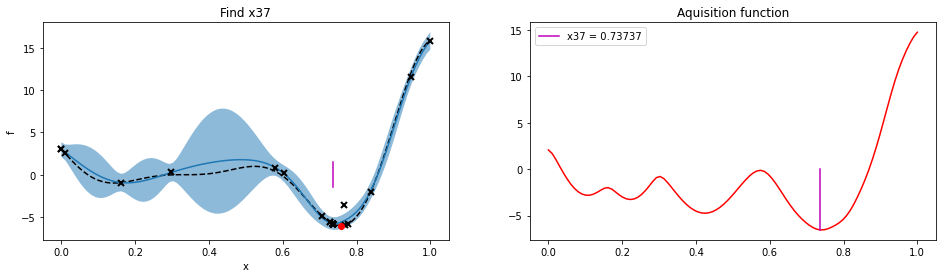

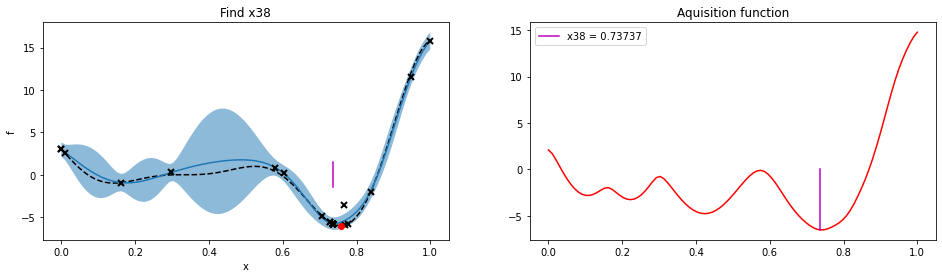

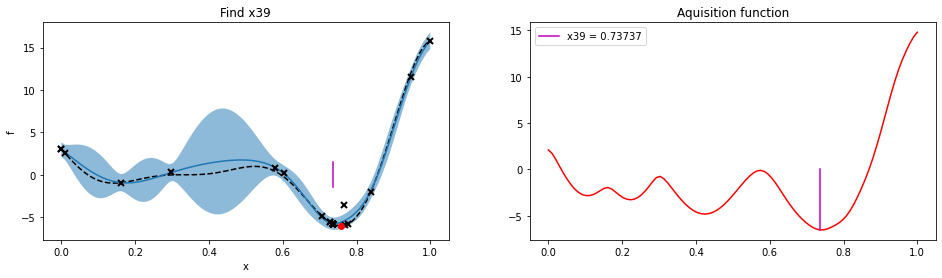

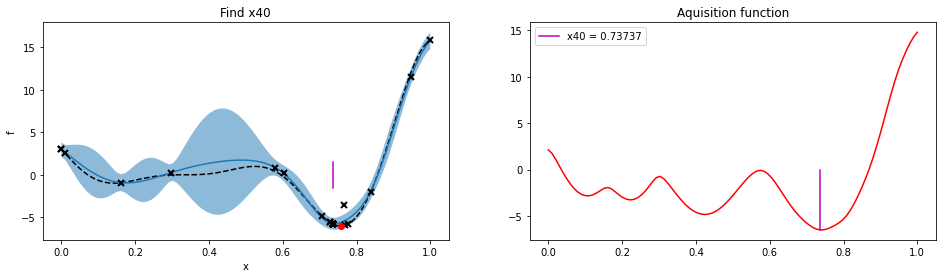

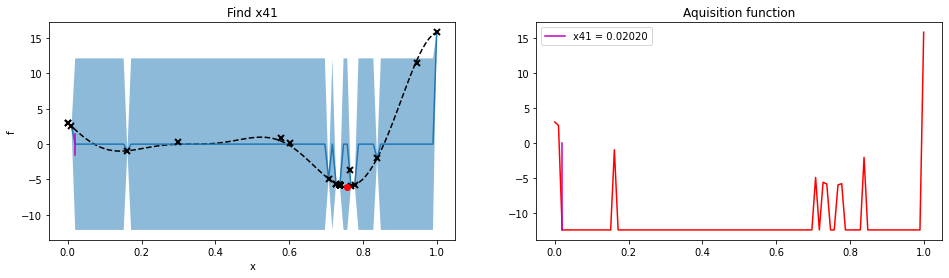

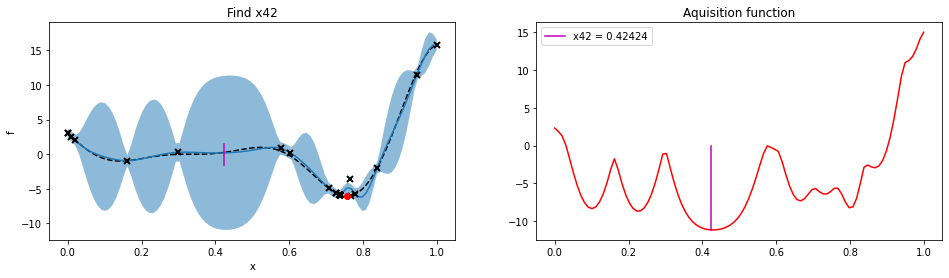

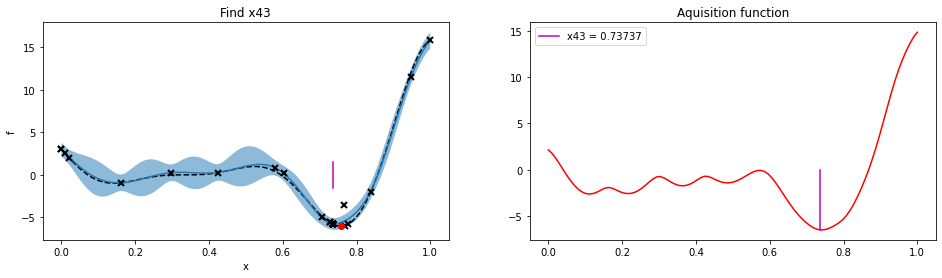

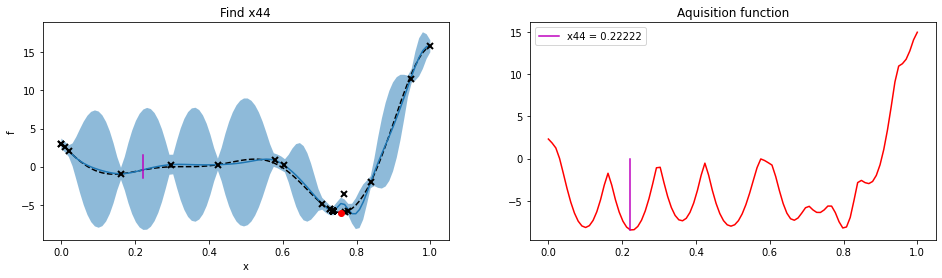

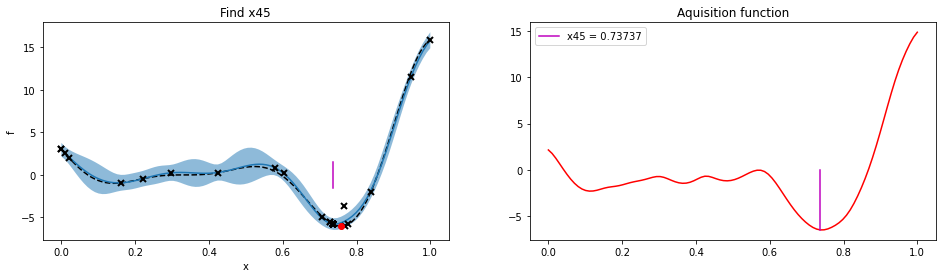

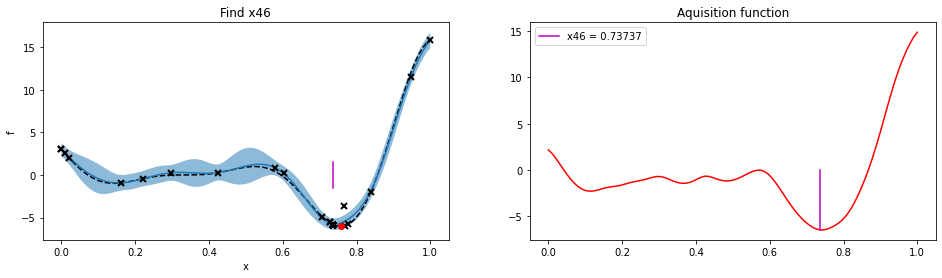

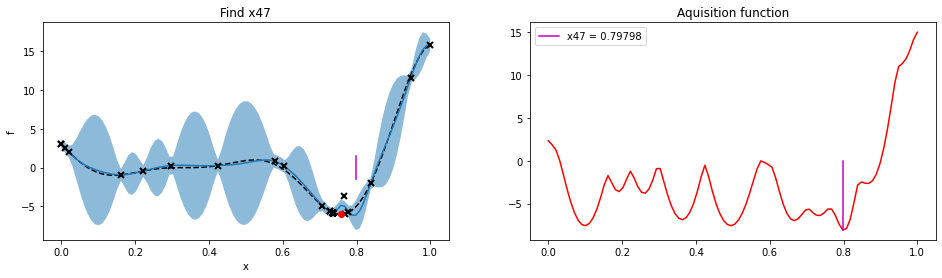

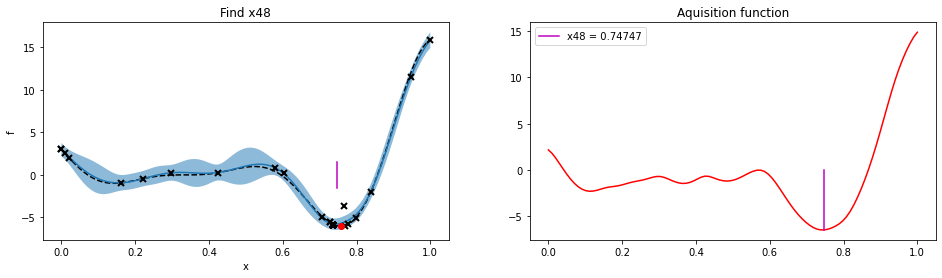

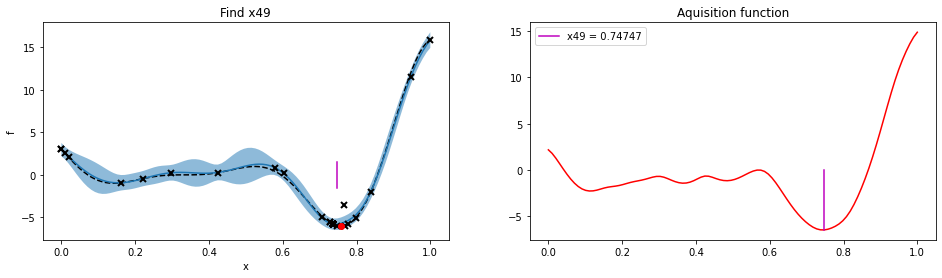

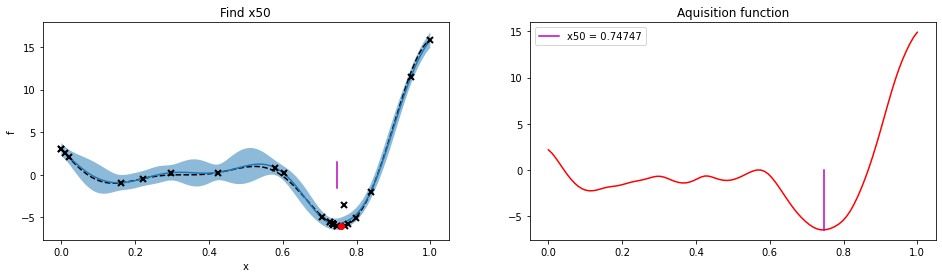

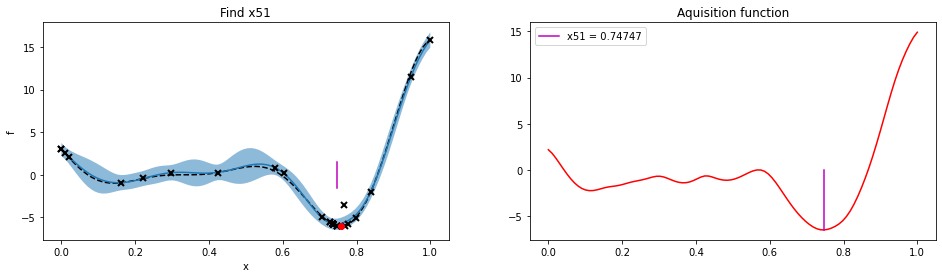

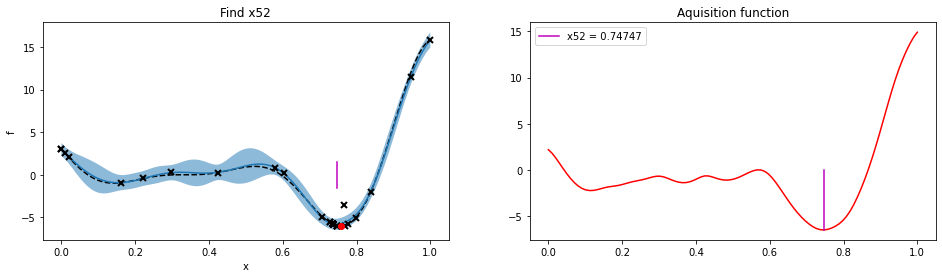

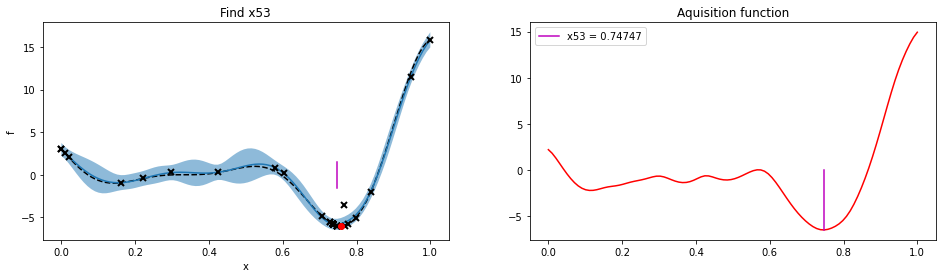

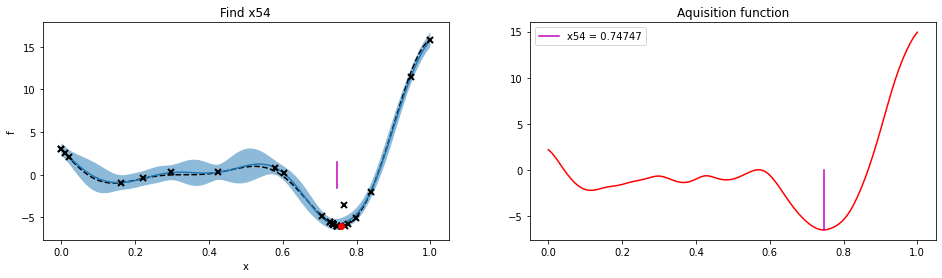

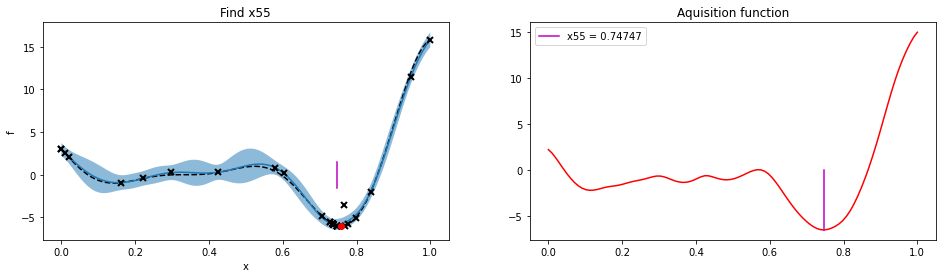

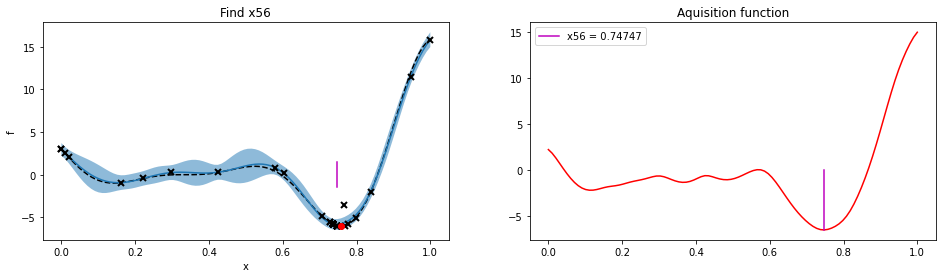

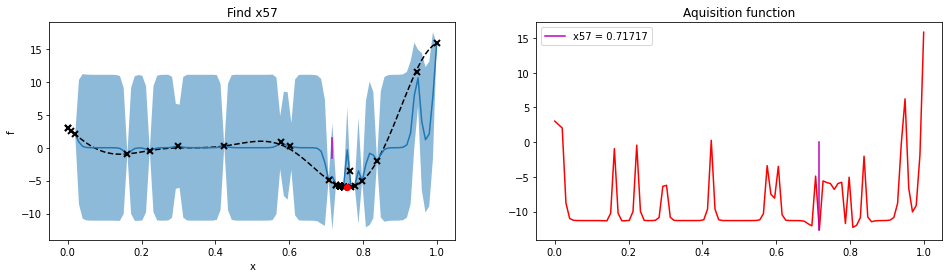

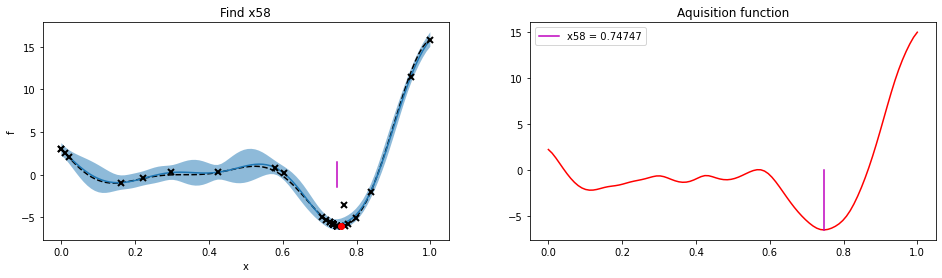

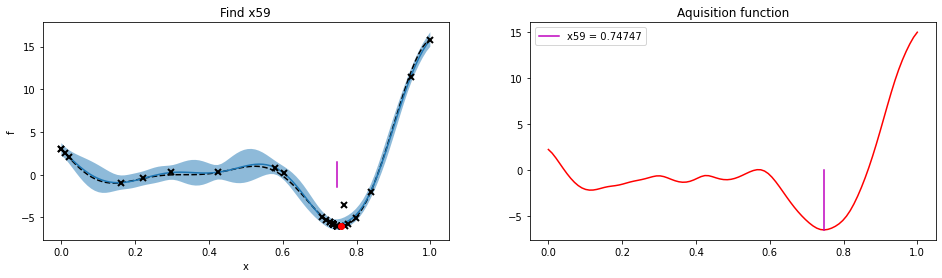

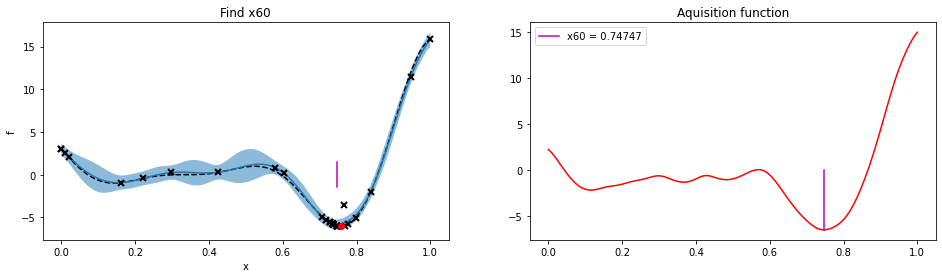

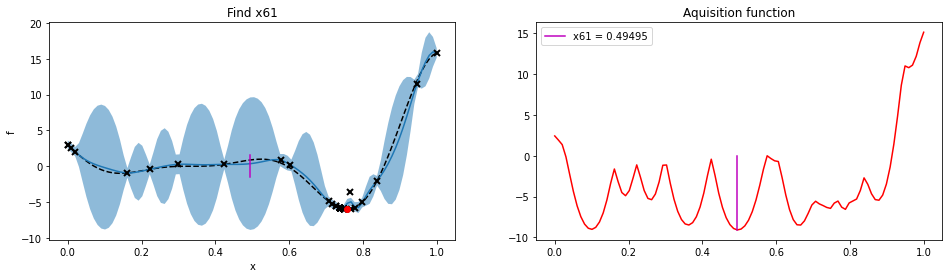

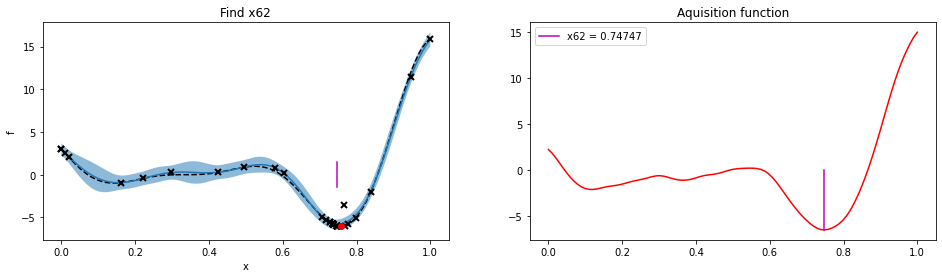

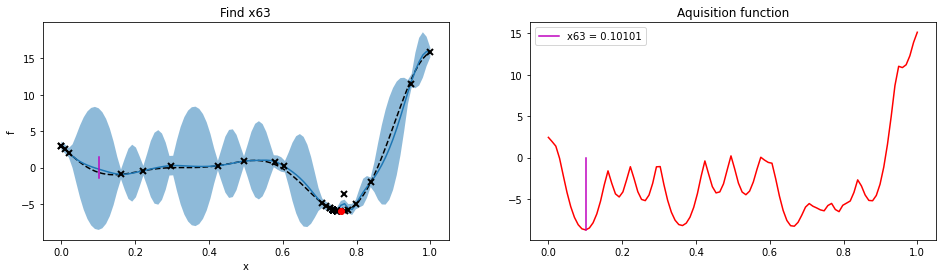

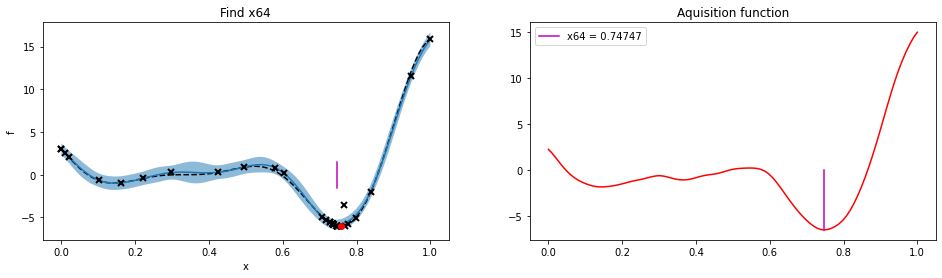

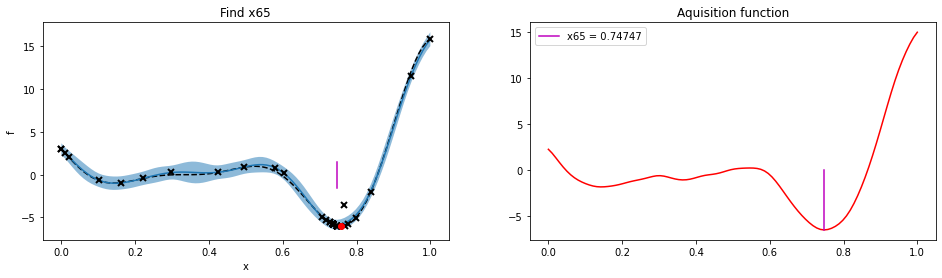

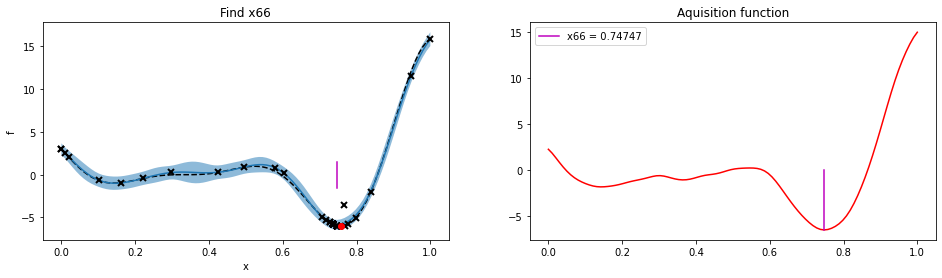

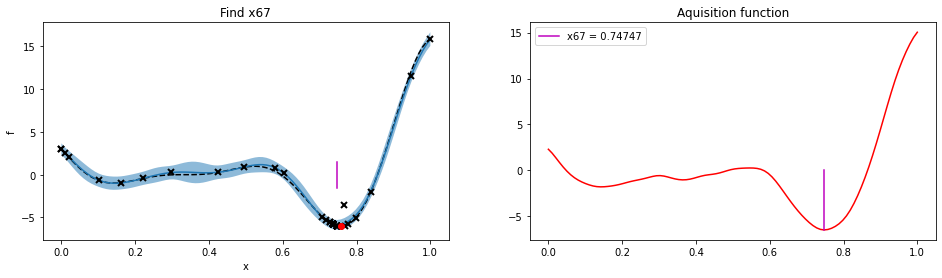

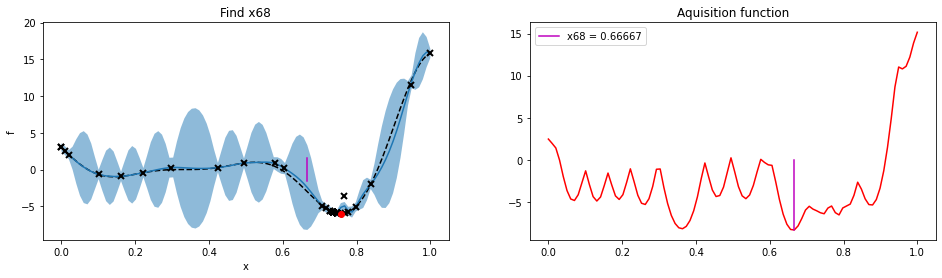

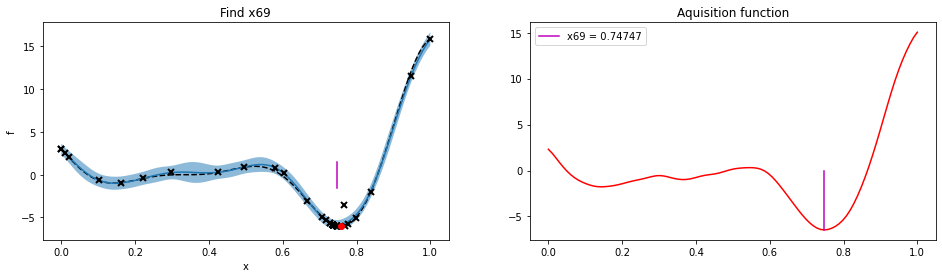

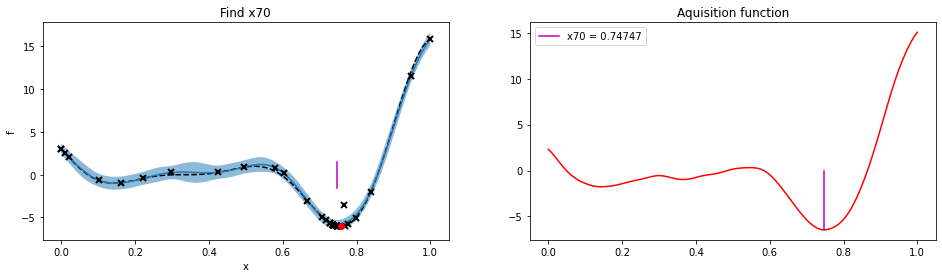

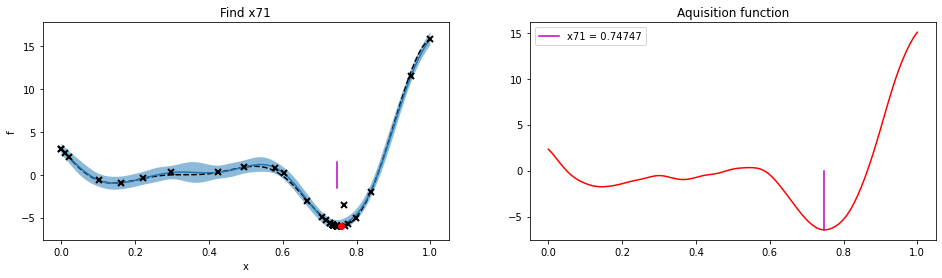

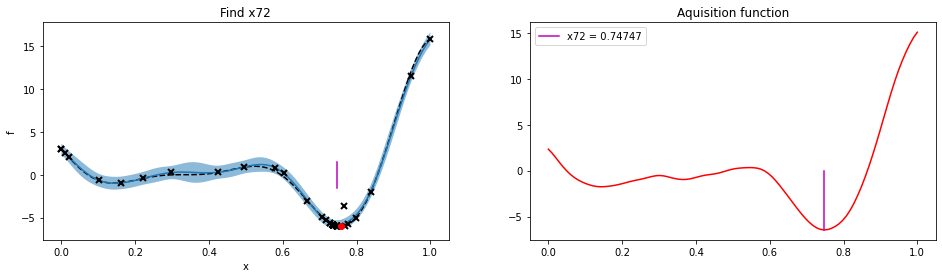

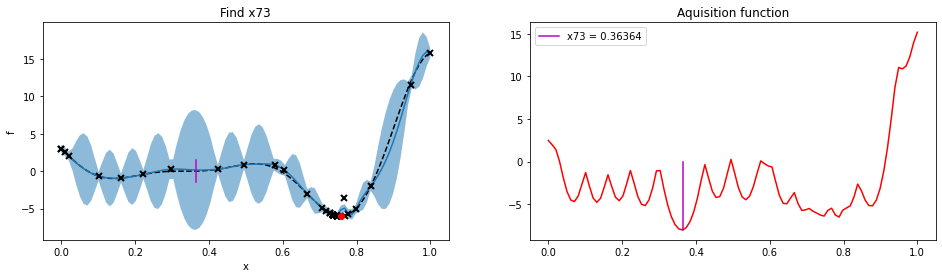

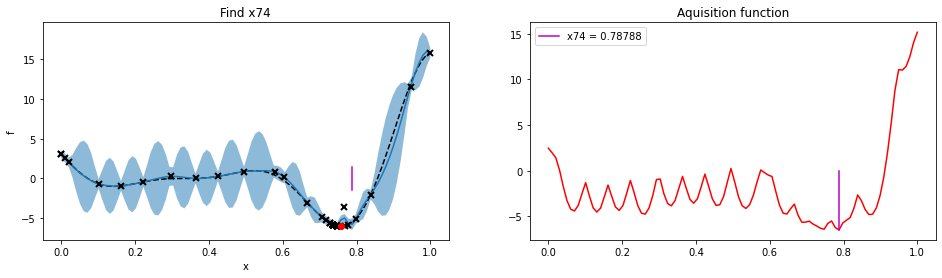

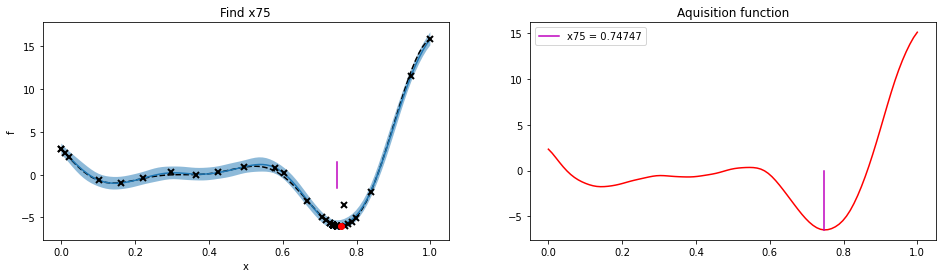

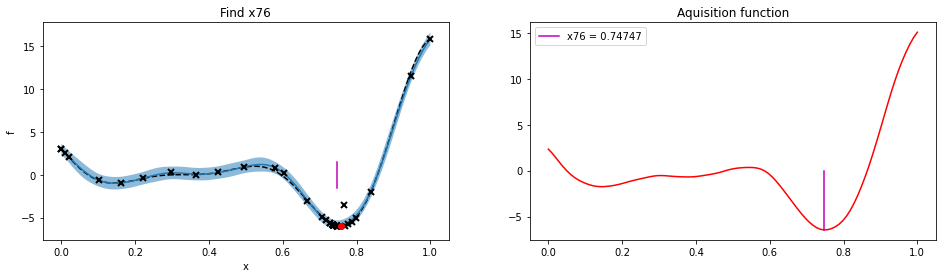

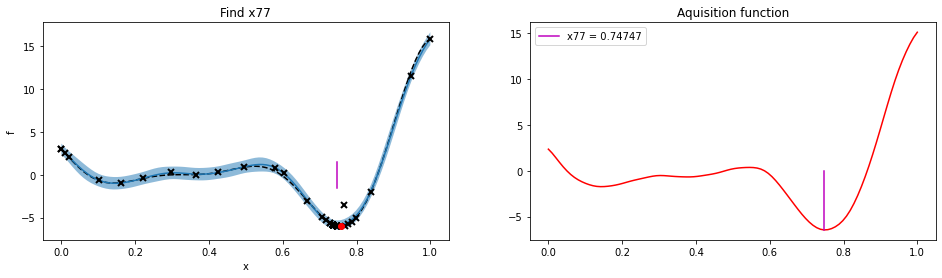

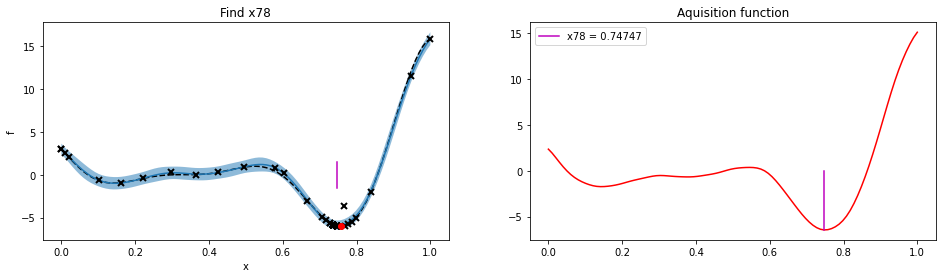

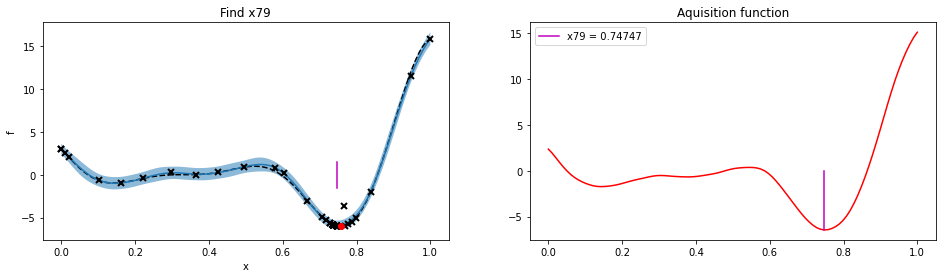

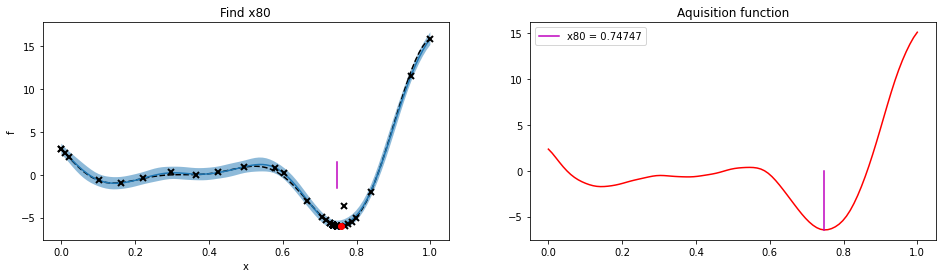

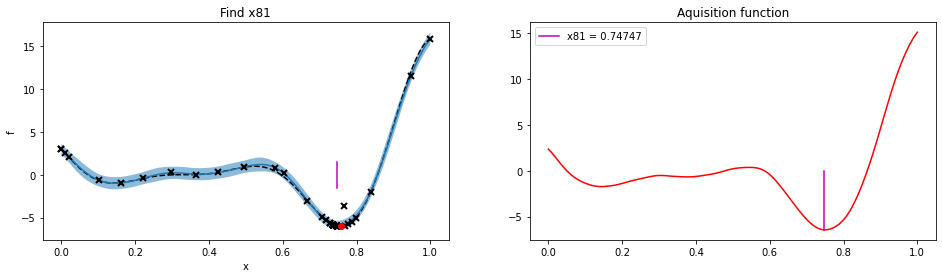

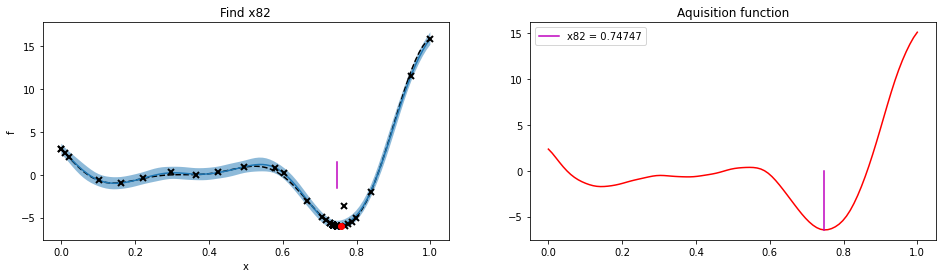

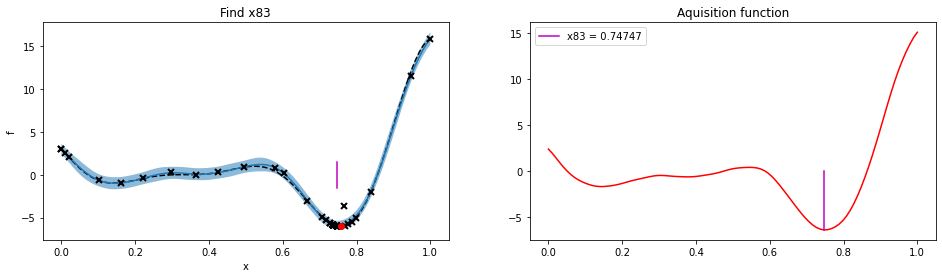

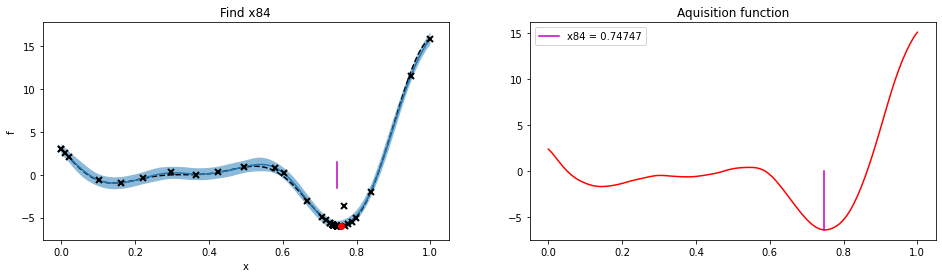

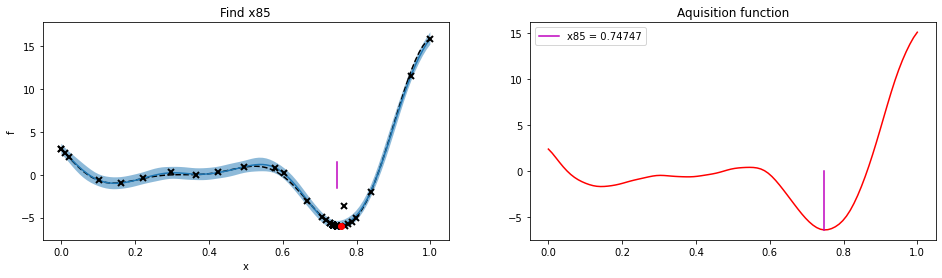

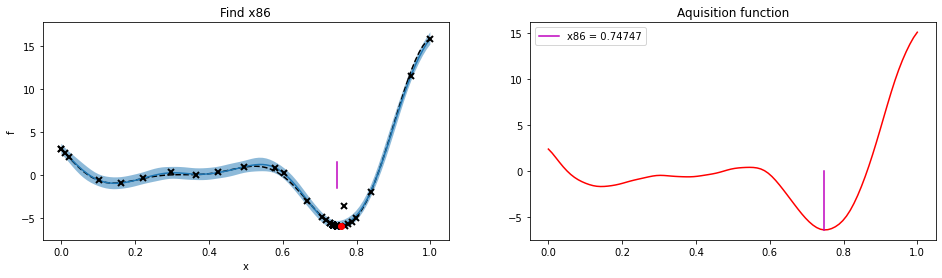

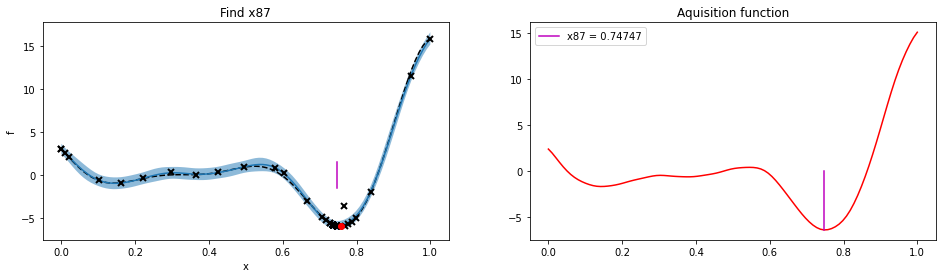

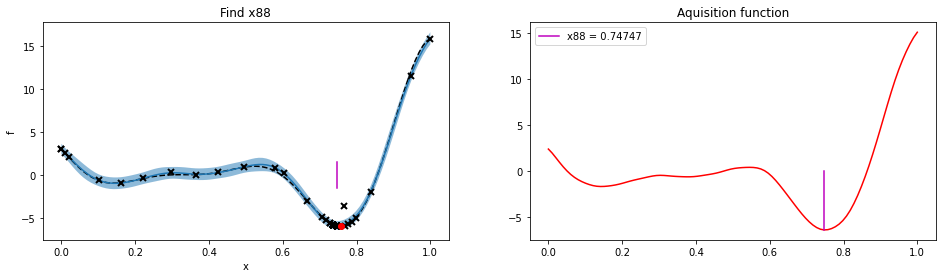

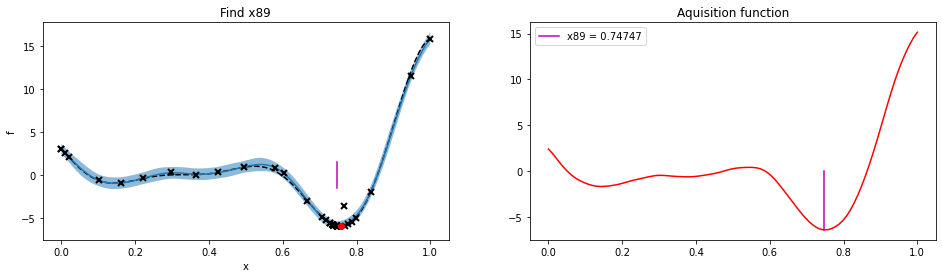

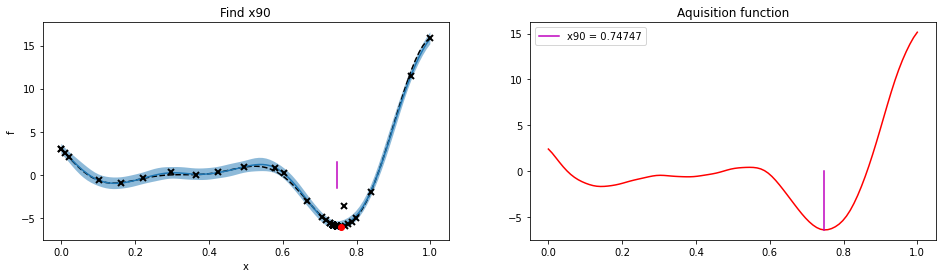

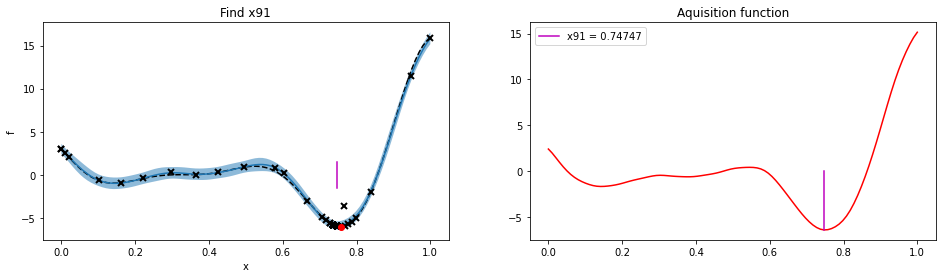

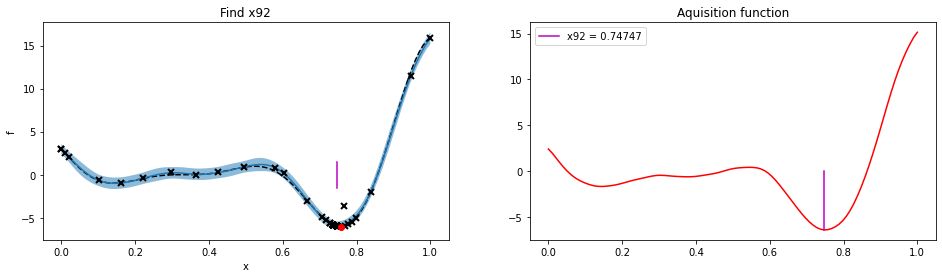

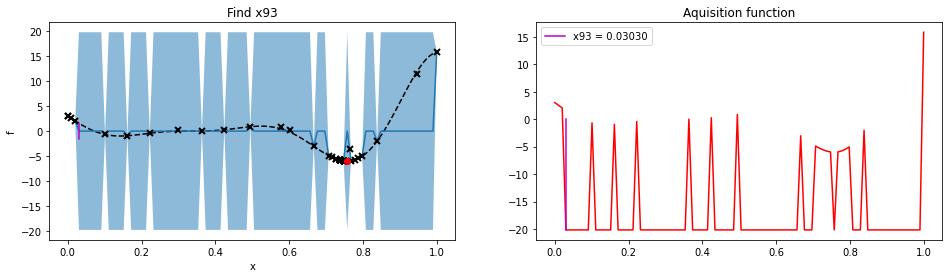

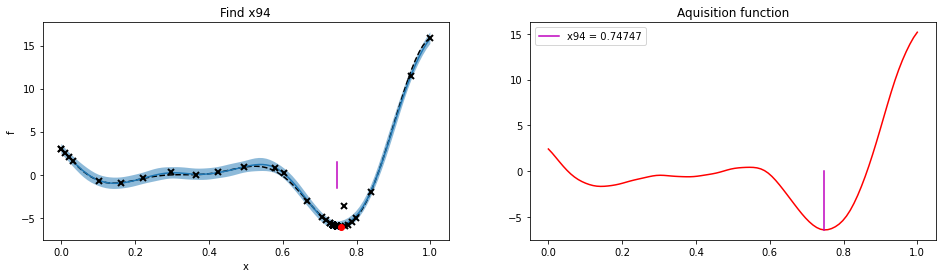

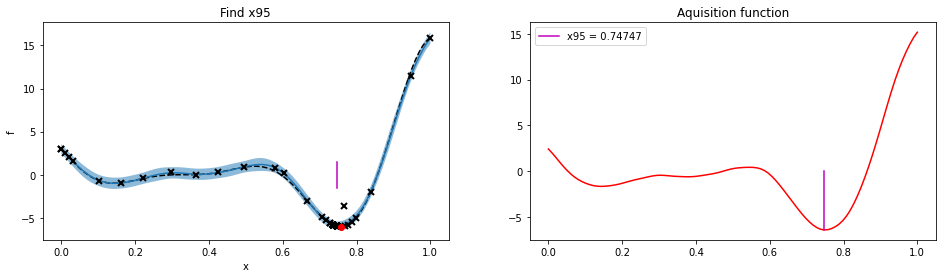

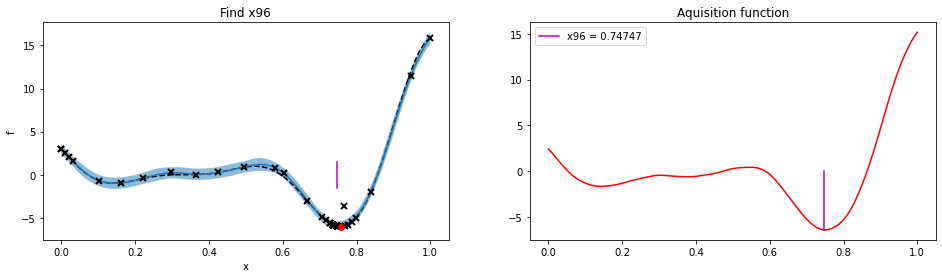

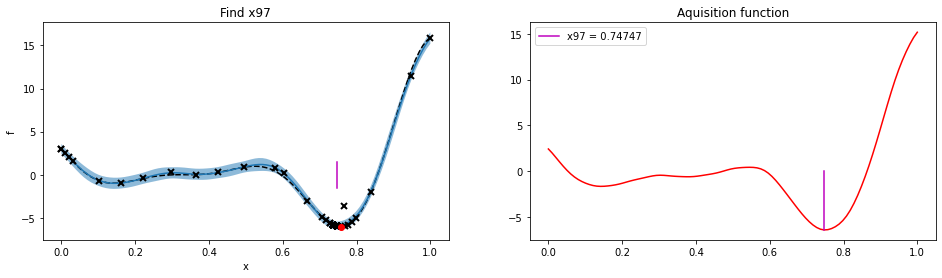

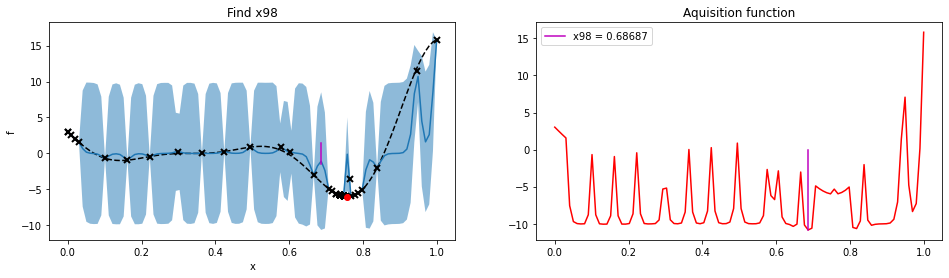

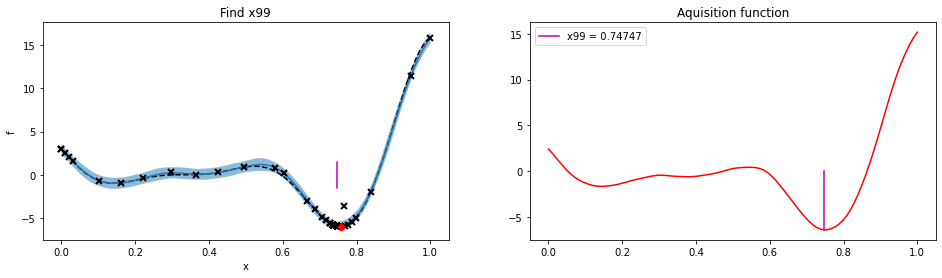

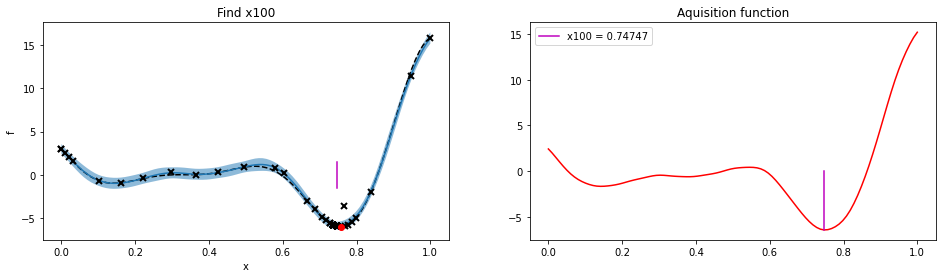

In [192]:
# BO by minimizing mean
num_measurements = 5
Number_of_iterations = 100

# The value (y) and position (x) of the true min
true_min_y = np.min(Y_grid)
true_min_x = X_grid[np.argmin(Y_grid)]


# Random sample locations
X_samples =  np.random.uniform(0., 1.0,(num_measurements, 1))


# Get the function value with noise
Y_samples = f(X_samples)+ np.random.normal(0., 1, (X_samples.shape[0],1))





# We will use this matrix to store the GP mean at every iteration.
Y_estimates = np.full((len(X_grid),Number_of_iterations),np.nan)


def lower_confidence_bound(mu, variance, kappa=2):
    # we will use k =2
    
    sigma = np.sqrt(variance)
    return mu.flatten() - kappa * sigma



for i in range(0, Number_of_iterations):
    
    # Use GP regression to fit the data
    mean, Cov, variance, m = GP_analysis(X_samples, Y_samples, X_grid)
    
    # find the x value where the GP reaches a minimum
    
    alpha_full = lower_confidence_bound(mean, variance, kappa=2) #lower_confidence_bound(mean, variance)  # <------  aquisition function
    next_sample_index = np.argmin(alpha_full)
    
    
    
    # This plots the objective function, with a magneta line where we want to sample next.
    # The red dot shows where the minimum is.
    xlabel=i+1
    plot_BO_results(X_grid, Y_grid, mean, Cov, alpha_full, X_samples, Y_samples, next_sample_index, true_min_x, true_min_y, xlabel)
    
    # add the desired sample to our data
    X_samples = np.vstack((X_samples,X_grid[next_sample_index,:]))
    Y_samples = np.vstack((Y_samples,Y_grid[next_sample_index,0]))
    
    # Store the GP mean for this iteration.
    Y_estimates[:,i] = mean.ravel()